# ARIMA Forecasting

## 1. Setup

In [126]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import figure as figure
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.eval_measures import mse, rmse, meanabs
from statsmodels.graphics.tsaplots import plot_predict
import datetime
from tabulate import tabulate
from pmdarima.arima import auto_arima

## 2. Preparation

In [154]:
file_path= "/Users/robinvandenberg/Desktop/Desktop – Robin’s MacBook Pro/Thesis/Data/main_new.xlsx"
main = pd.read_excel(file_path)
main = main.set_index(main['time'])
main = main.drop(['Unnamed: 0', 'time'], axis=1) #remove unnecessary index column
main

Spot Close   Spot Volume  CQF Close   CQF Volume  \
time                                                                    
2019-07-21 13:00:00     10542.0  1.052900e+00   10656.50       0.0000   
2019-07-21 13:15:00     10584.0  0.000000e+00   10701.50       0.0000   
2019-07-21 13:30:00     10568.0  0.000000e+00   10686.00       0.0000   
2019-07-21 13:45:00     10535.5  0.000000e+00   10648.00       0.0000   
2019-07-21 14:00:00     10531.0  0.000000e+00   10637.25       0.0000   
...                         ...           ...        ...          ...   
2022-04-30 21:00:00     38278.0  6.148997e+06   38380.00  479102.9521   
2022-04-30 21:15:00     38325.0  4.012060e+06   38431.00   94022.4783   
2022-04-30 21:30:00     38355.0  3.339375e+06   38460.00   41562.1715   
2022-04-30 21:45:00     38304.0  1.276453e+06   38416.00   45640.5218   
2022-04-30 22:00:00     38239.0  4.431048e+06   38353.00  206411.5591   

                     NQF Close   NQF Volume      diff  
time                                                   
2019-07-21 13:00:00        0.0       0.0000 -10656.50  
2019-07-21 13:15:00        0.0       0.0000 -10701.50  
2019-07-21 13:30:00        0.0       0.0000 -10686.00  
2019-07-21 13:45:00        0.0       0.0000 -10648.00  
2019-07-21 14:00:00        0.0       0.0000 -10637.25  
...                        ...          ...       ...  
2022-04-30 21:00:00    38690.0  121668.0480    310.00  
2022-04-30 21:15:00    38753.0    5289.7845    322.00  
2022-04-30 21:30:00    38779.0     976.3274    319.00  
2022-04-30 21:45:00    38737.0    1945.0568    321.00  
2022-04-30 22:00:00    38654.0    3701.9621    301.00  

[97364 rows x 7 columns]

In [155]:
# Both volume columns have zero values. So we need the minimum non-zero values. 
non_zero_cqf_vol = []
for i in range(0, len(main['CQF Volume'])):
    if main['CQF Volume'][i] != 0:
        non_zero_cqf_vol.append(main['CQF Volume'][i])

non_zero_spot_vol = []
for i in range(0, len(main['Spot Volume'])):
    if main['Spot Volume'][i] != 0:
        non_zero_spot_vol.append(main['Spot Volume'][i])

min(non_zero_cqf_vol), min(non_zero_spot_vol)

(0.6133, 0.7171)

In [156]:
# Define the log current quarter future price
main['log_price'] = np.log(main['CQF Close'])
# Define the log returns for the current quarter future price
main['returns'] = np.log(main['CQF Close']).diff()
# Define the lagged log returns for the current quarter future price
main['lag_returns'] = main['returns'].shift(1)
# Define the log volume for the current quarter future
main['cqf_log_vol'] = np.log(main['CQF Volume'] + min(non_zero_cqf_vol))
# Define the lagged log volume for the current quarter future
main['lag_cqf_log_vol'] = main['cqf_log_vol'].shift(1)
# Define the change in volume for the current quarter future
main['change_cqf_vol'] = main['cqf_log_vol'].diff()
main = main[2:]
main = main[datetime.datetime(2021, 7, 1, 0, 0):datetime.datetime(2022, 1, 1, 0, 0)]
main = main.reset_index()
main

time  Spot Close   Spot Volume  CQF Close    CQF Volume  \
0     2021-07-01 00:00:00     34839.0  5.199493e+06    35444.0  1.215913e+06   
1     2021-07-01 00:15:00     34799.0  3.870319e+06    35421.0  1.409117e+06   
2     2021-07-01 00:30:00     34770.0  1.793630e+06    35359.0  7.386256e+05   
3     2021-07-01 00:45:00     34737.0  1.605401e+06    35333.0  4.248566e+05   
4     2021-07-01 01:00:00     34818.0  1.969387e+06    35421.0  4.434615e+05   
...                   ...         ...           ...        ...           ...   
17660 2021-12-31 23:00:00     46428.0  1.703140e+06    47368.0  1.586354e+06   
17661 2021-12-31 23:15:00     46359.0  1.285162e+06    47298.0  8.838602e+05   
17662 2021-12-31 23:30:00     46462.0  1.794594e+06    47402.0  1.699350e+06   
17663 2021-12-31 23:45:00     46199.0  3.233099e+06    47157.0  9.339795e+05   
17664 2022-01-01 00:00:00     46323.0  4.388561e+06    47289.0  7.630552e+05   

       NQF Close    NQF Volume    diff  log_price   returns  lag_returns  \
0        36132.0  2.280265e+05   688.0  10.475709 -0.006552    -0.001540   
1        36094.0  1.309984e+06   673.0  10.475060 -0.000649    -0.006552   
2        36036.0  3.538730e+04   677.0  10.473308 -0.001752    -0.000649   
3        36010.0  1.875510e+04   677.0  10.472573 -0.000736    -0.001752   
4        36090.0  4.580032e+04   669.0  10.475060  0.002487    -0.000736   
...          ...           ...     ...        ...       ...          ...   
17660    48624.0  3.681412e+05  1256.0  10.765702  0.002515     0.000127   
17661    48532.0  3.993435e+05  1234.0  10.764223 -0.001479     0.002515   
17662    48719.0  1.353783e+06  1317.0  10.766420  0.002196    -0.001479   
17663    48443.0  6.101699e+05  1286.0  10.761238 -0.005182     0.002196   
17664    48549.0  7.324975e+05  1260.0  10.764033  0.002795    -0.005182   

       cqf_log_vol  lag_cqf_log_vol  change_cqf_vol  
0        14.011006        13.696937        0.314069  
1        14.158475        14.011006        0.147468  
2        13.512547        14.158475       -0.645927  
3        12.959508        13.512547       -0.553039  
4        13.002368        12.959508        0.042859  
...            ...              ...             ...  
17660    14.276949        14.371471       -0.094522  
17661    13.692055        14.276949       -0.584894  
17662    14.345756        13.692055        0.653702  
17663    13.747210        14.345756       -0.598546  
17664    13.545086        13.747210       -0.202124  

[17665 rows x 14 columns]

# 3. Model Specification

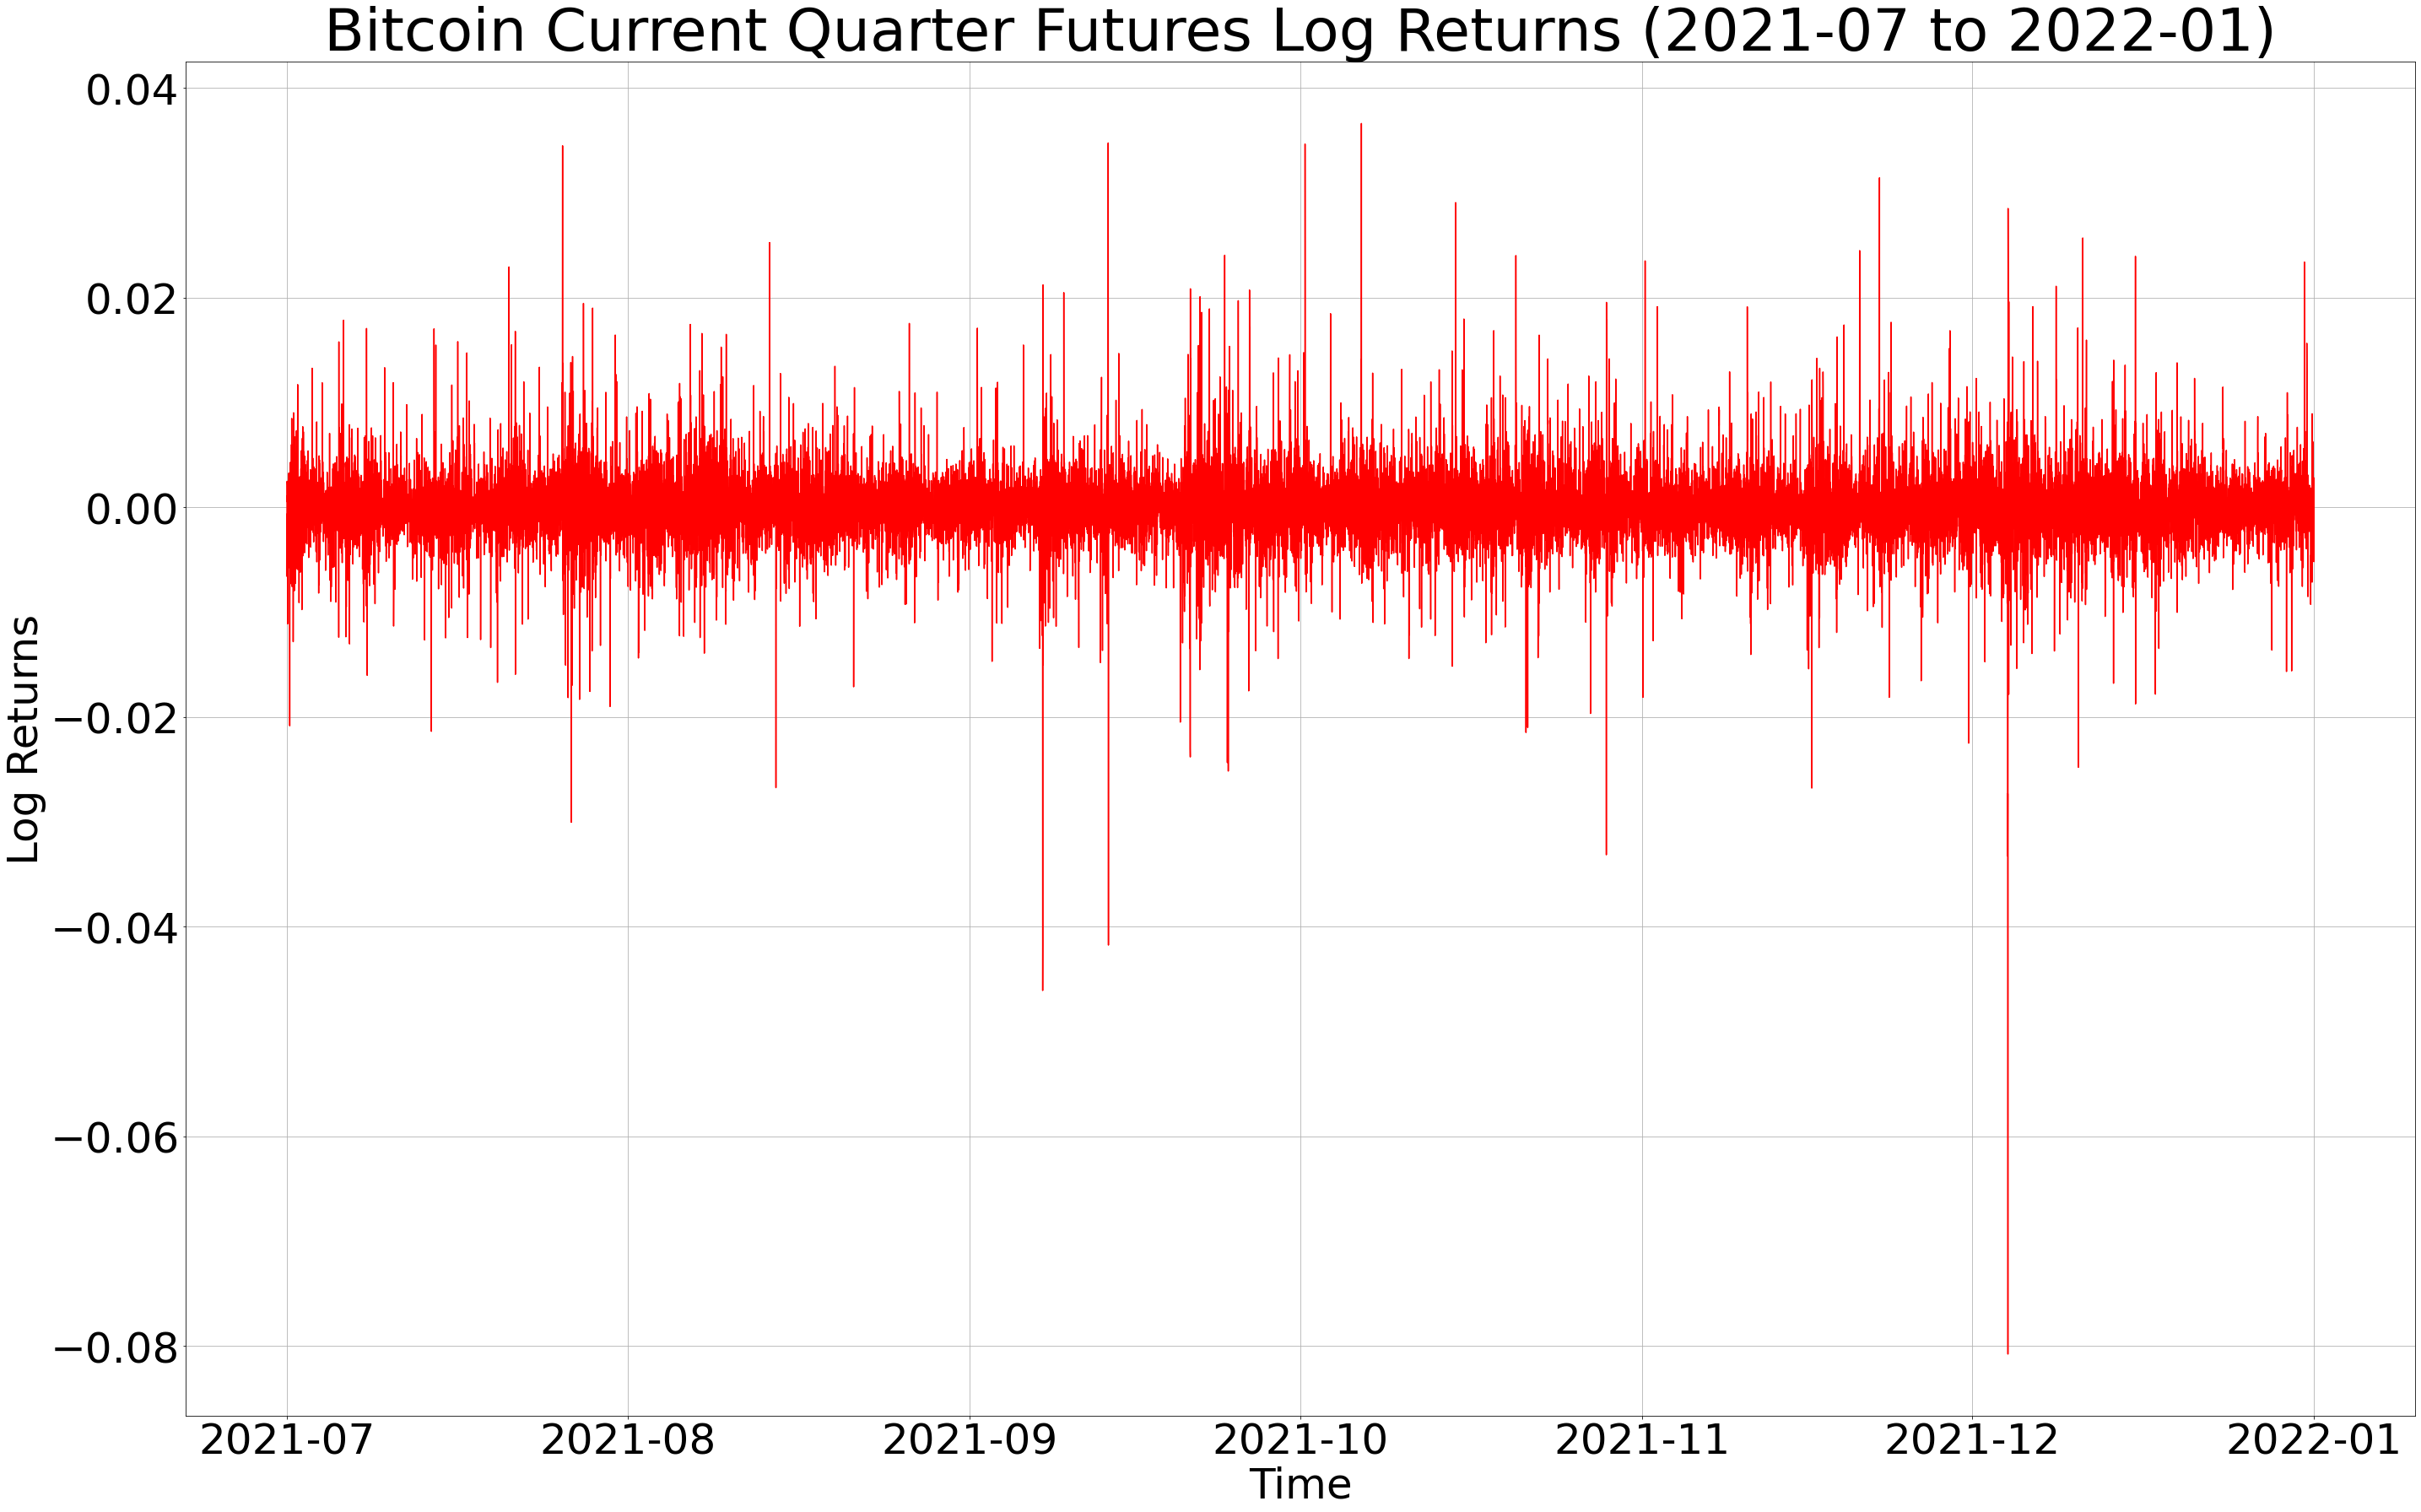

In [33]:
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (40,25)

ax.plot(main['returns'], color='red') 

ax.set_xlabel('Time', fontsize=50)
ax.set_ylabel('Log Returns', fontsize=50)
plt.title('Bitcoin Current Quarter Futures Log Returns (2021-07 to 2022-01)', fontsize=70)

ax.grid(True)
ax.tick_params(axis='both', which='major', labelsize=50)

plt.tight_layout()
plt.savefig('/Users/robinvandenberg/Desktop/Desktop – Robin’s MacBook Pro/Thesis/Scripts/Figures/Returns2021.pdf')
plt.show()

In [7]:
ADF = adfuller(main['returns'], autolag='BIC', regression='ct')

table = [
    ['Test Statistic', ADF[0]],
    ['p-value', ADF[1]],
    ['Lags', ADF[2]],
    ['Critical Values', ' '],
    ['10%', ADF[4]['10%'] ], 
    ['5%', ADF[4]['5%'] ], 
    ['1%', ADF[4]['1%'] ],
    ['Constant & Trend', 'included'],
    ['Lag Selection Method', 'BIC']
]

tab = tabulate(table, headers=['ADF',' '])

tab = pd.DataFrame(table, columns=[' ', 'ADF Test'])
tab = tab.set_index(' ')


with open('/Users/robinvandenberg/Desktop/Thesis/Scripts/Tables/ADF.tex','w') as tf:
    tf.write(tab.to_latex())

tab

/var/folders/tv/yf2rtv1j16z862b1fzdggrth0000gn/T/ipykernel_87977/2006273142.py:22: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tf.write(tab.to_latex())


ADF Test
                               
Test Statistic       -87.664621
p-value                     0.0
Lags                          1
Critical Values                
10%                   -3.127226
5%                    -3.410789
1%                    -3.959387
Constant & Trend       included
Lag Selection Method        BIC

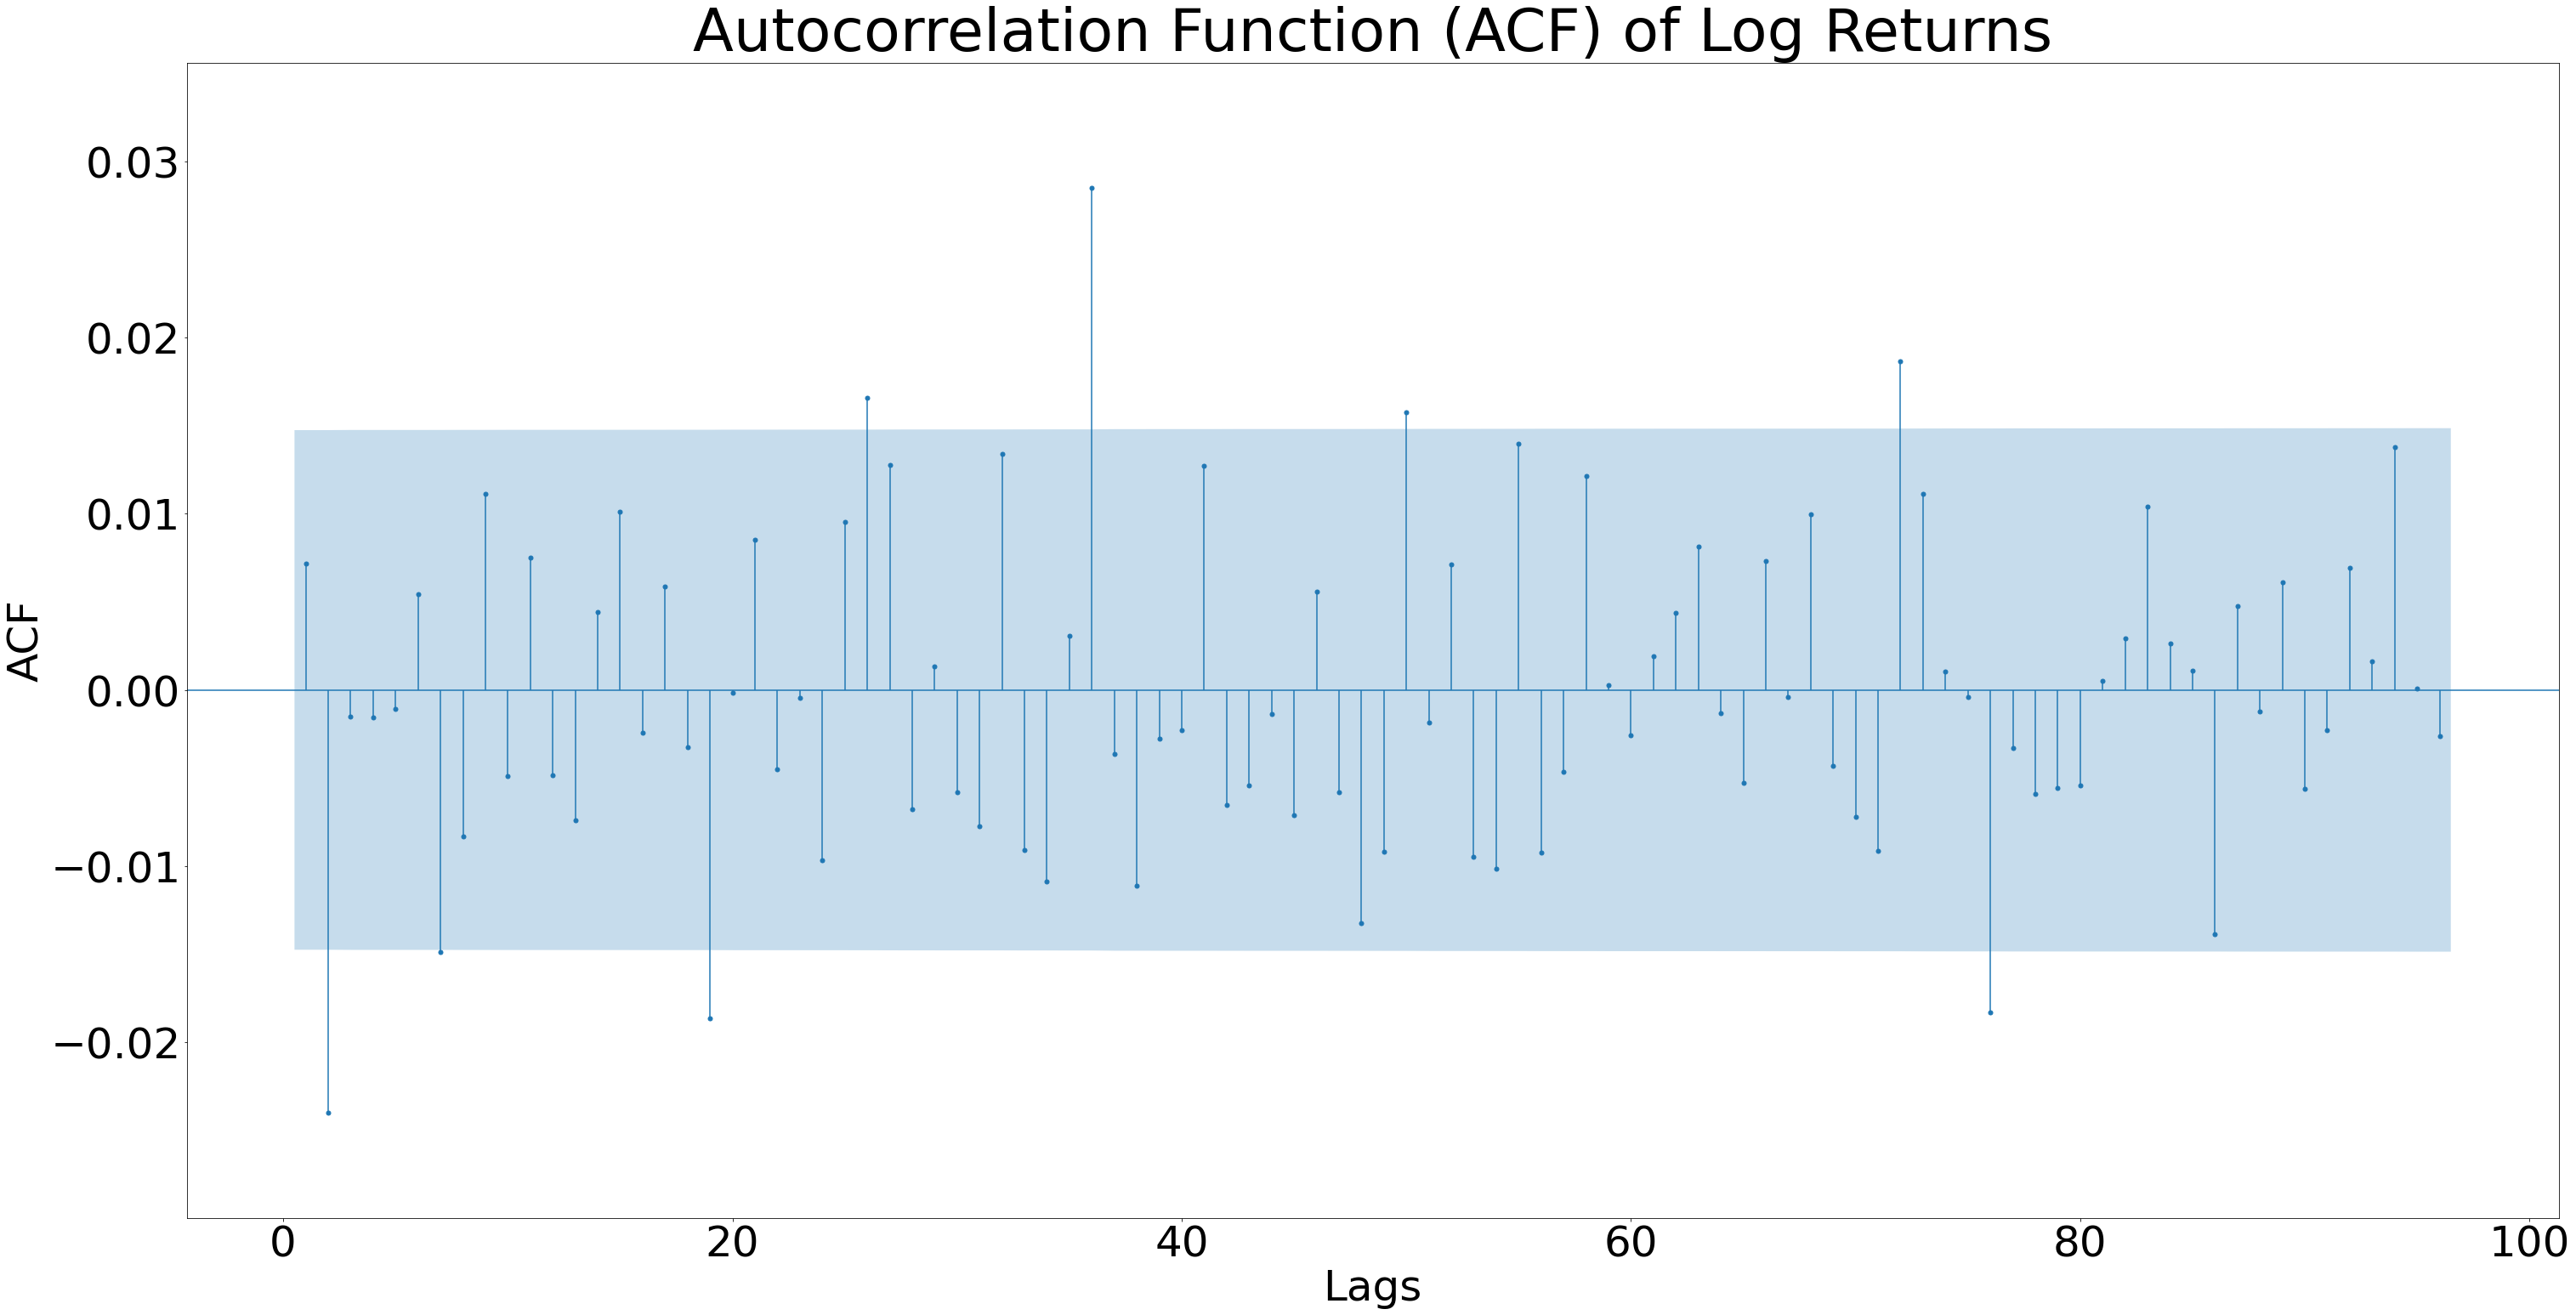

In [143]:
fig, ax1 = plt.subplots()

plt.rcParams["figure.figsize"] = (50,25)

plot_acf(main['returns'], zero=False, lags=4*24, auto_ylims=True, ax=ax1)

ax1.set_xlabel('Lags', fontsize=50)
ax1.set_ylabel('ACF', fontsize=50)
ax1.tick_params(axis='both', which='major', labelsize=50)
plt.title('Autocorrelation Function (ACF) of Log Returns', fontsize=70)


plt.savefig('/Users/robinvandenberg/Desktop/Desktop – Robin’s MacBook Pro/Thesis/Scripts/Figures/ACF.pdf')

plt.show()

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


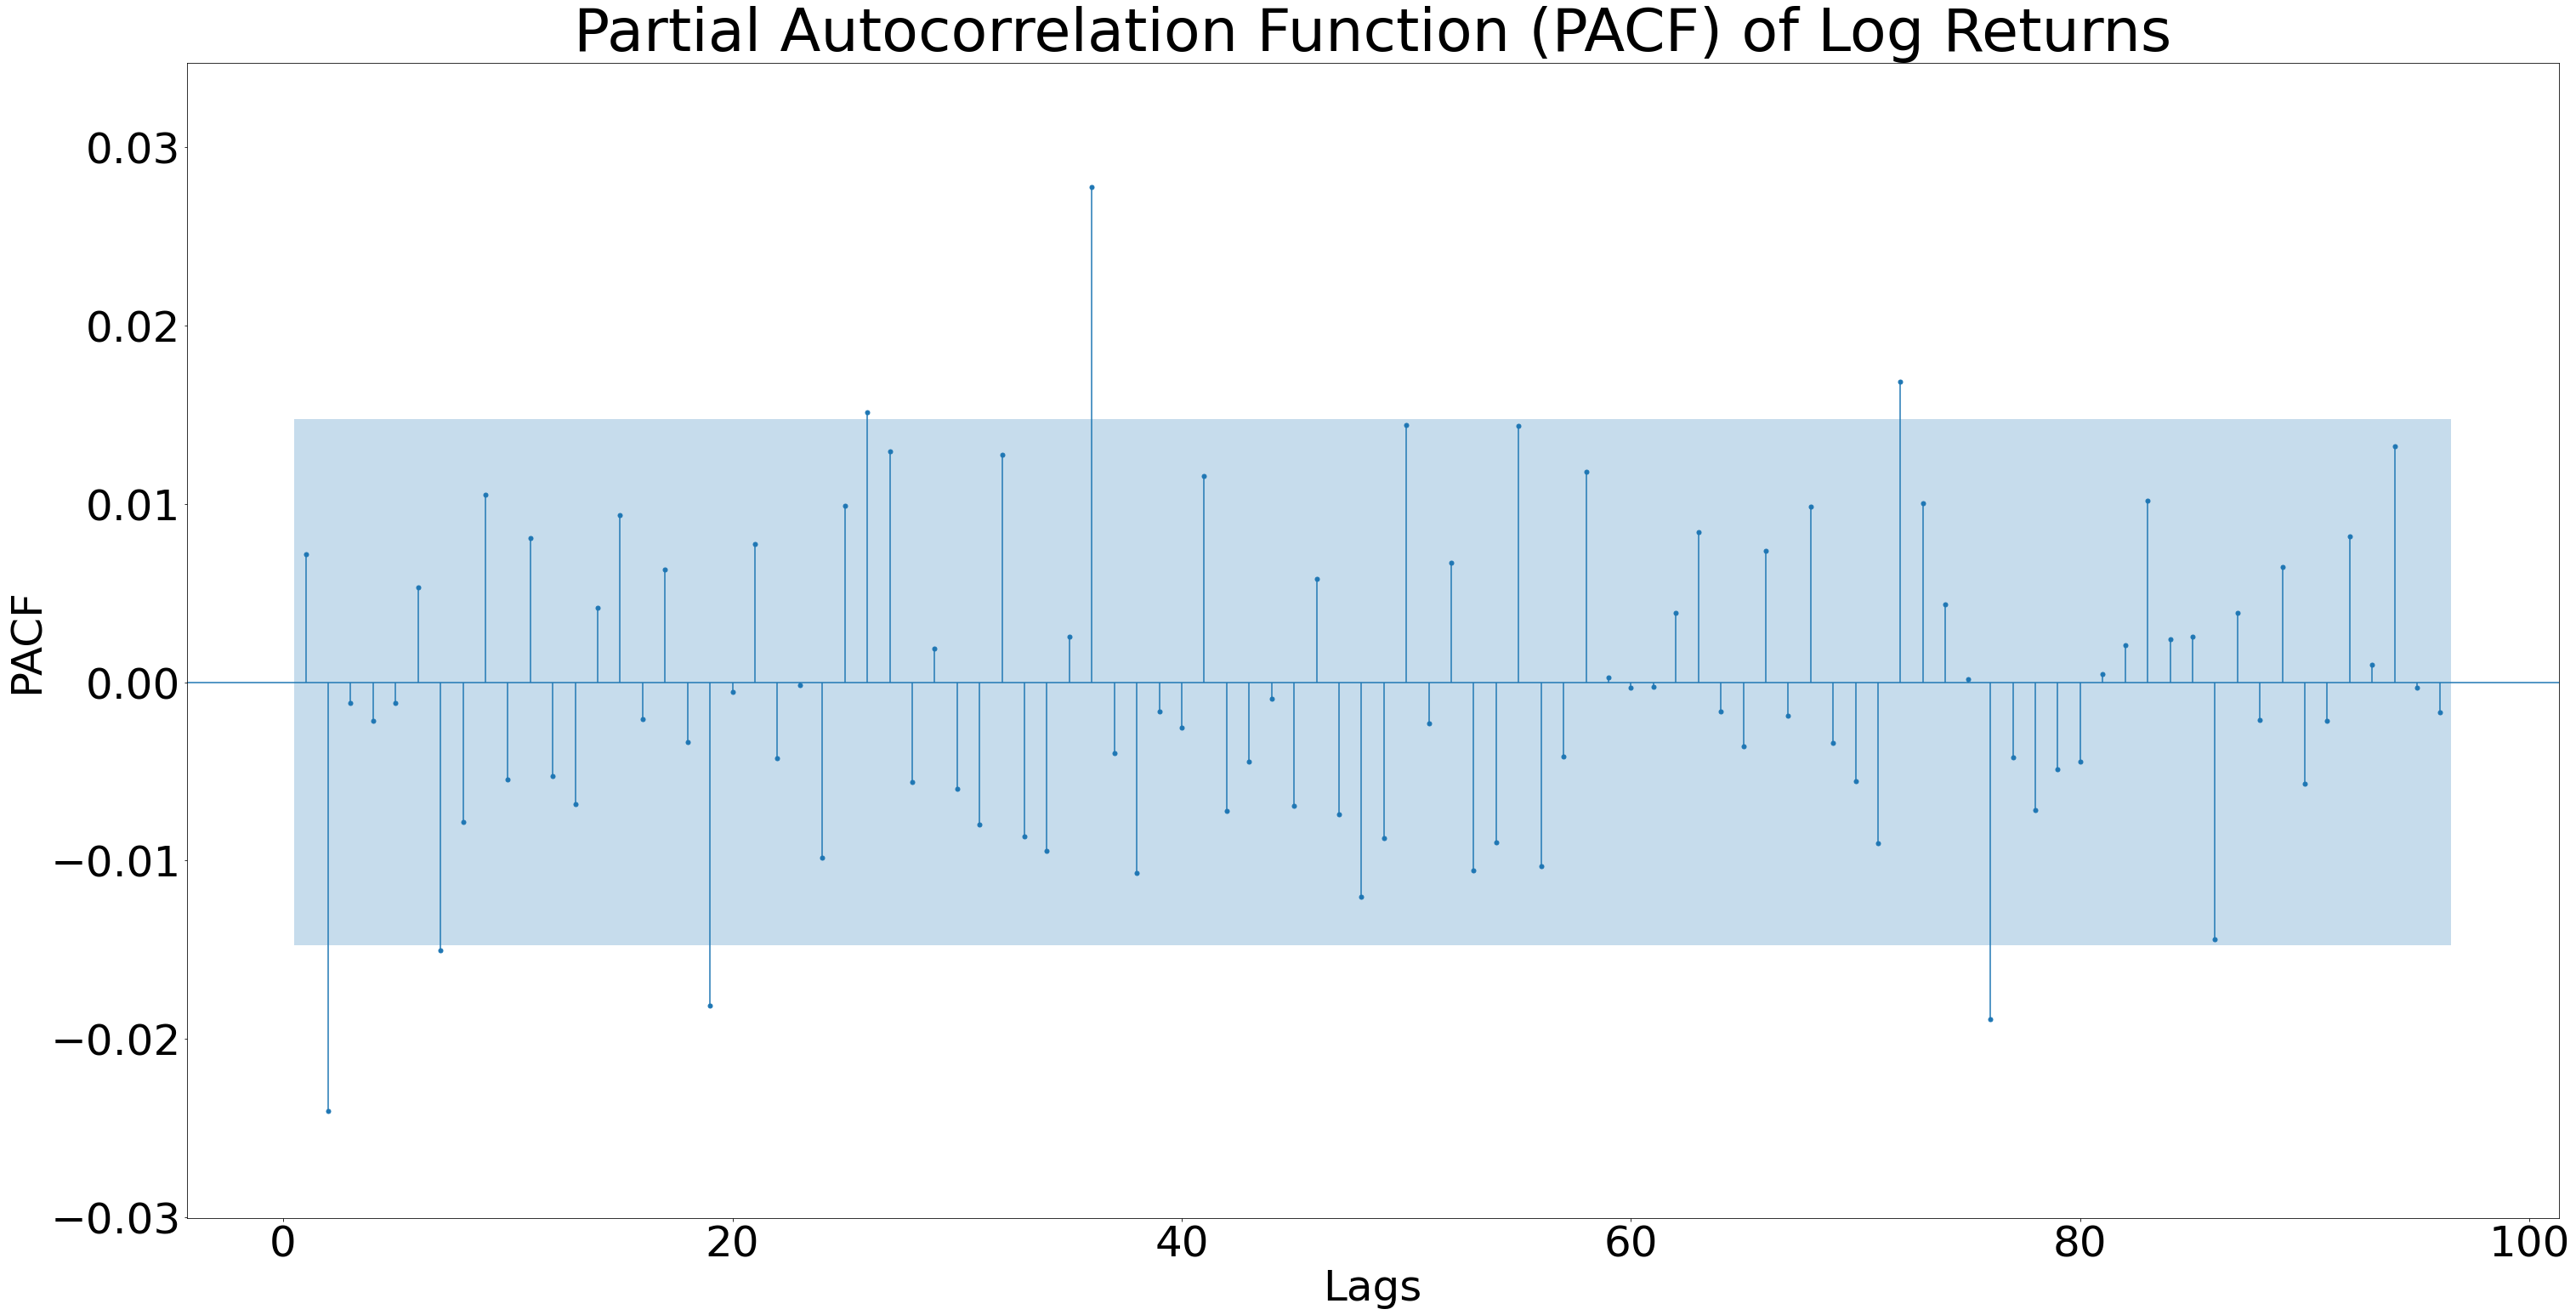

In [144]:
fig, ax1 = plt.subplots()

plt.rcParams["figure.figsize"] = (50,25)

plot_pacf(main['returns'], zero=False, lags=4*24, auto_ylims=True, ax=ax1)

ax1.set_xlabel('Lags', fontsize=50)
ax1.set_ylabel('PACF', fontsize=50)
ax1.tick_params(axis='both', which='major', labelsize=50)
plt.title('Partial Autocorrelation Function (PACF) of Log Returns', fontsize=70)


plt.savefig('/Users/robinvandenberg/Desktop/Desktop – Robin’s MacBook Pro/Thesis/Scripts/Figures/PACF.pdf')

plt.show()

In [146]:
# create training sample data set
train_size = int(0.85 * len(main))
train = main[:train_size]
test = main[train_size:]

In [147]:
auto_arima(train['returns'], seasonal=False)

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: Runtim

ARIMA(order=(0, 0, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

## ARIMA(0,0,2)

In [45]:
training = list(train['returns'])
pred1 = []

for i in range(len(test)):
    model = ARIMA(training, order=(0,0,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    pred1.append(output)
    training.append(test['returns'][i])
    

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

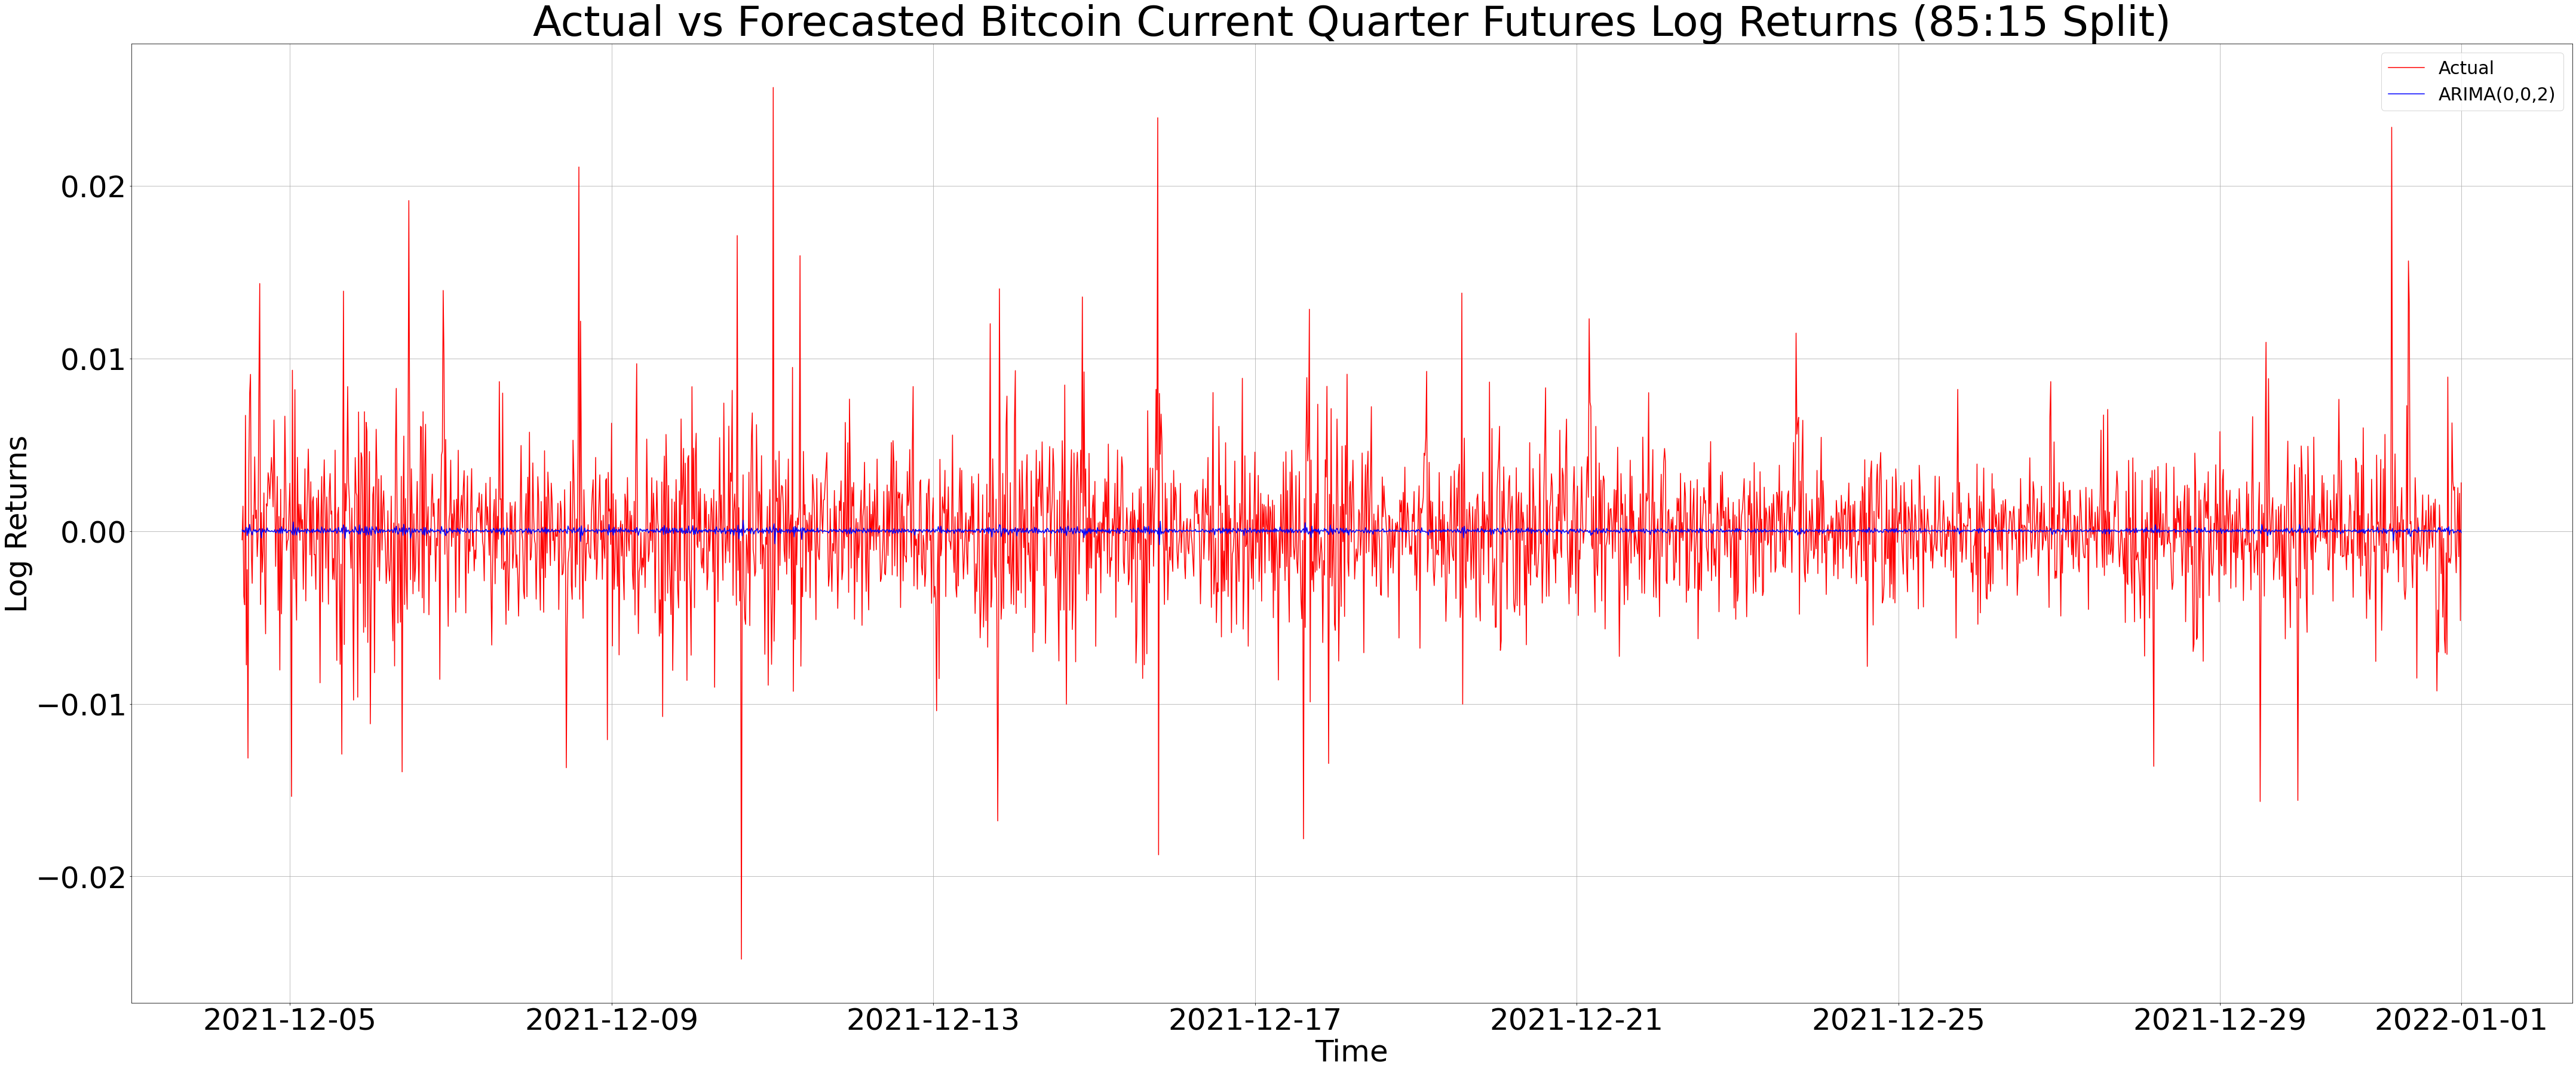

In [149]:
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (40,25)

ax.plot(test['time'], test['returns'], color='red', label='Actual')
ax.plot(test['time'], pred1, color='blue', label='ARIMA(0,0,2)')

ax.set_xlabel('Time', fontsize=50)
ax.set_ylabel('Log Returns', fontsize=50)
plt.title('Actual vs Forecasted Bitcoin Current Quarter Futures Log Returns (85:15 Split)', fontsize=70)

ax.grid(True)
ax.tick_params(axis='both', which='major', labelsize=50)
ax.legend(['Actual', 'ARIMA(0,0,2)'], prop={'size': 30})

plt.tight_layout()
plt.savefig('/Users/robinvandenberg/Desktop/Desktop – Robin’s MacBook Pro/Thesis/Scripts/Figures/ARIMA002.pdf')
plt.show()

In [135]:
# ARIMA(0,0,2)
from statsmodels.tools.eval_measures import mse, rmse, meanabs

mse002 = round(mse(np.array(test['returns']), np.array(out2['ARIMA(0,0,2)'])), ndigits=10)
rmse002 = round(rmse(np.array(test['returns']), np.array(out2['ARIMA(0,0,2)'])), ndigits=10)
mae002 = round(meanabs(np.array(test['returns']), np.array(out2['ARIMA(0,0,2)'])), ndigits=10)

print("MSE:  ", mse002)
print("RMSE: ", rmse002)
print("MAE:  ", mae002)

MSE:   1.24007e-05
RMSE:  0.0035214654
MAE:   0.0024968714


## ARIMA(4,0,0)

In [53]:
training = list(train['returns'])
pred2 = []

for i in range(len(test)):
    model = ARIMA(training, order=(4,0,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    pred2.append(output)
    training.append(test['returns'][i])

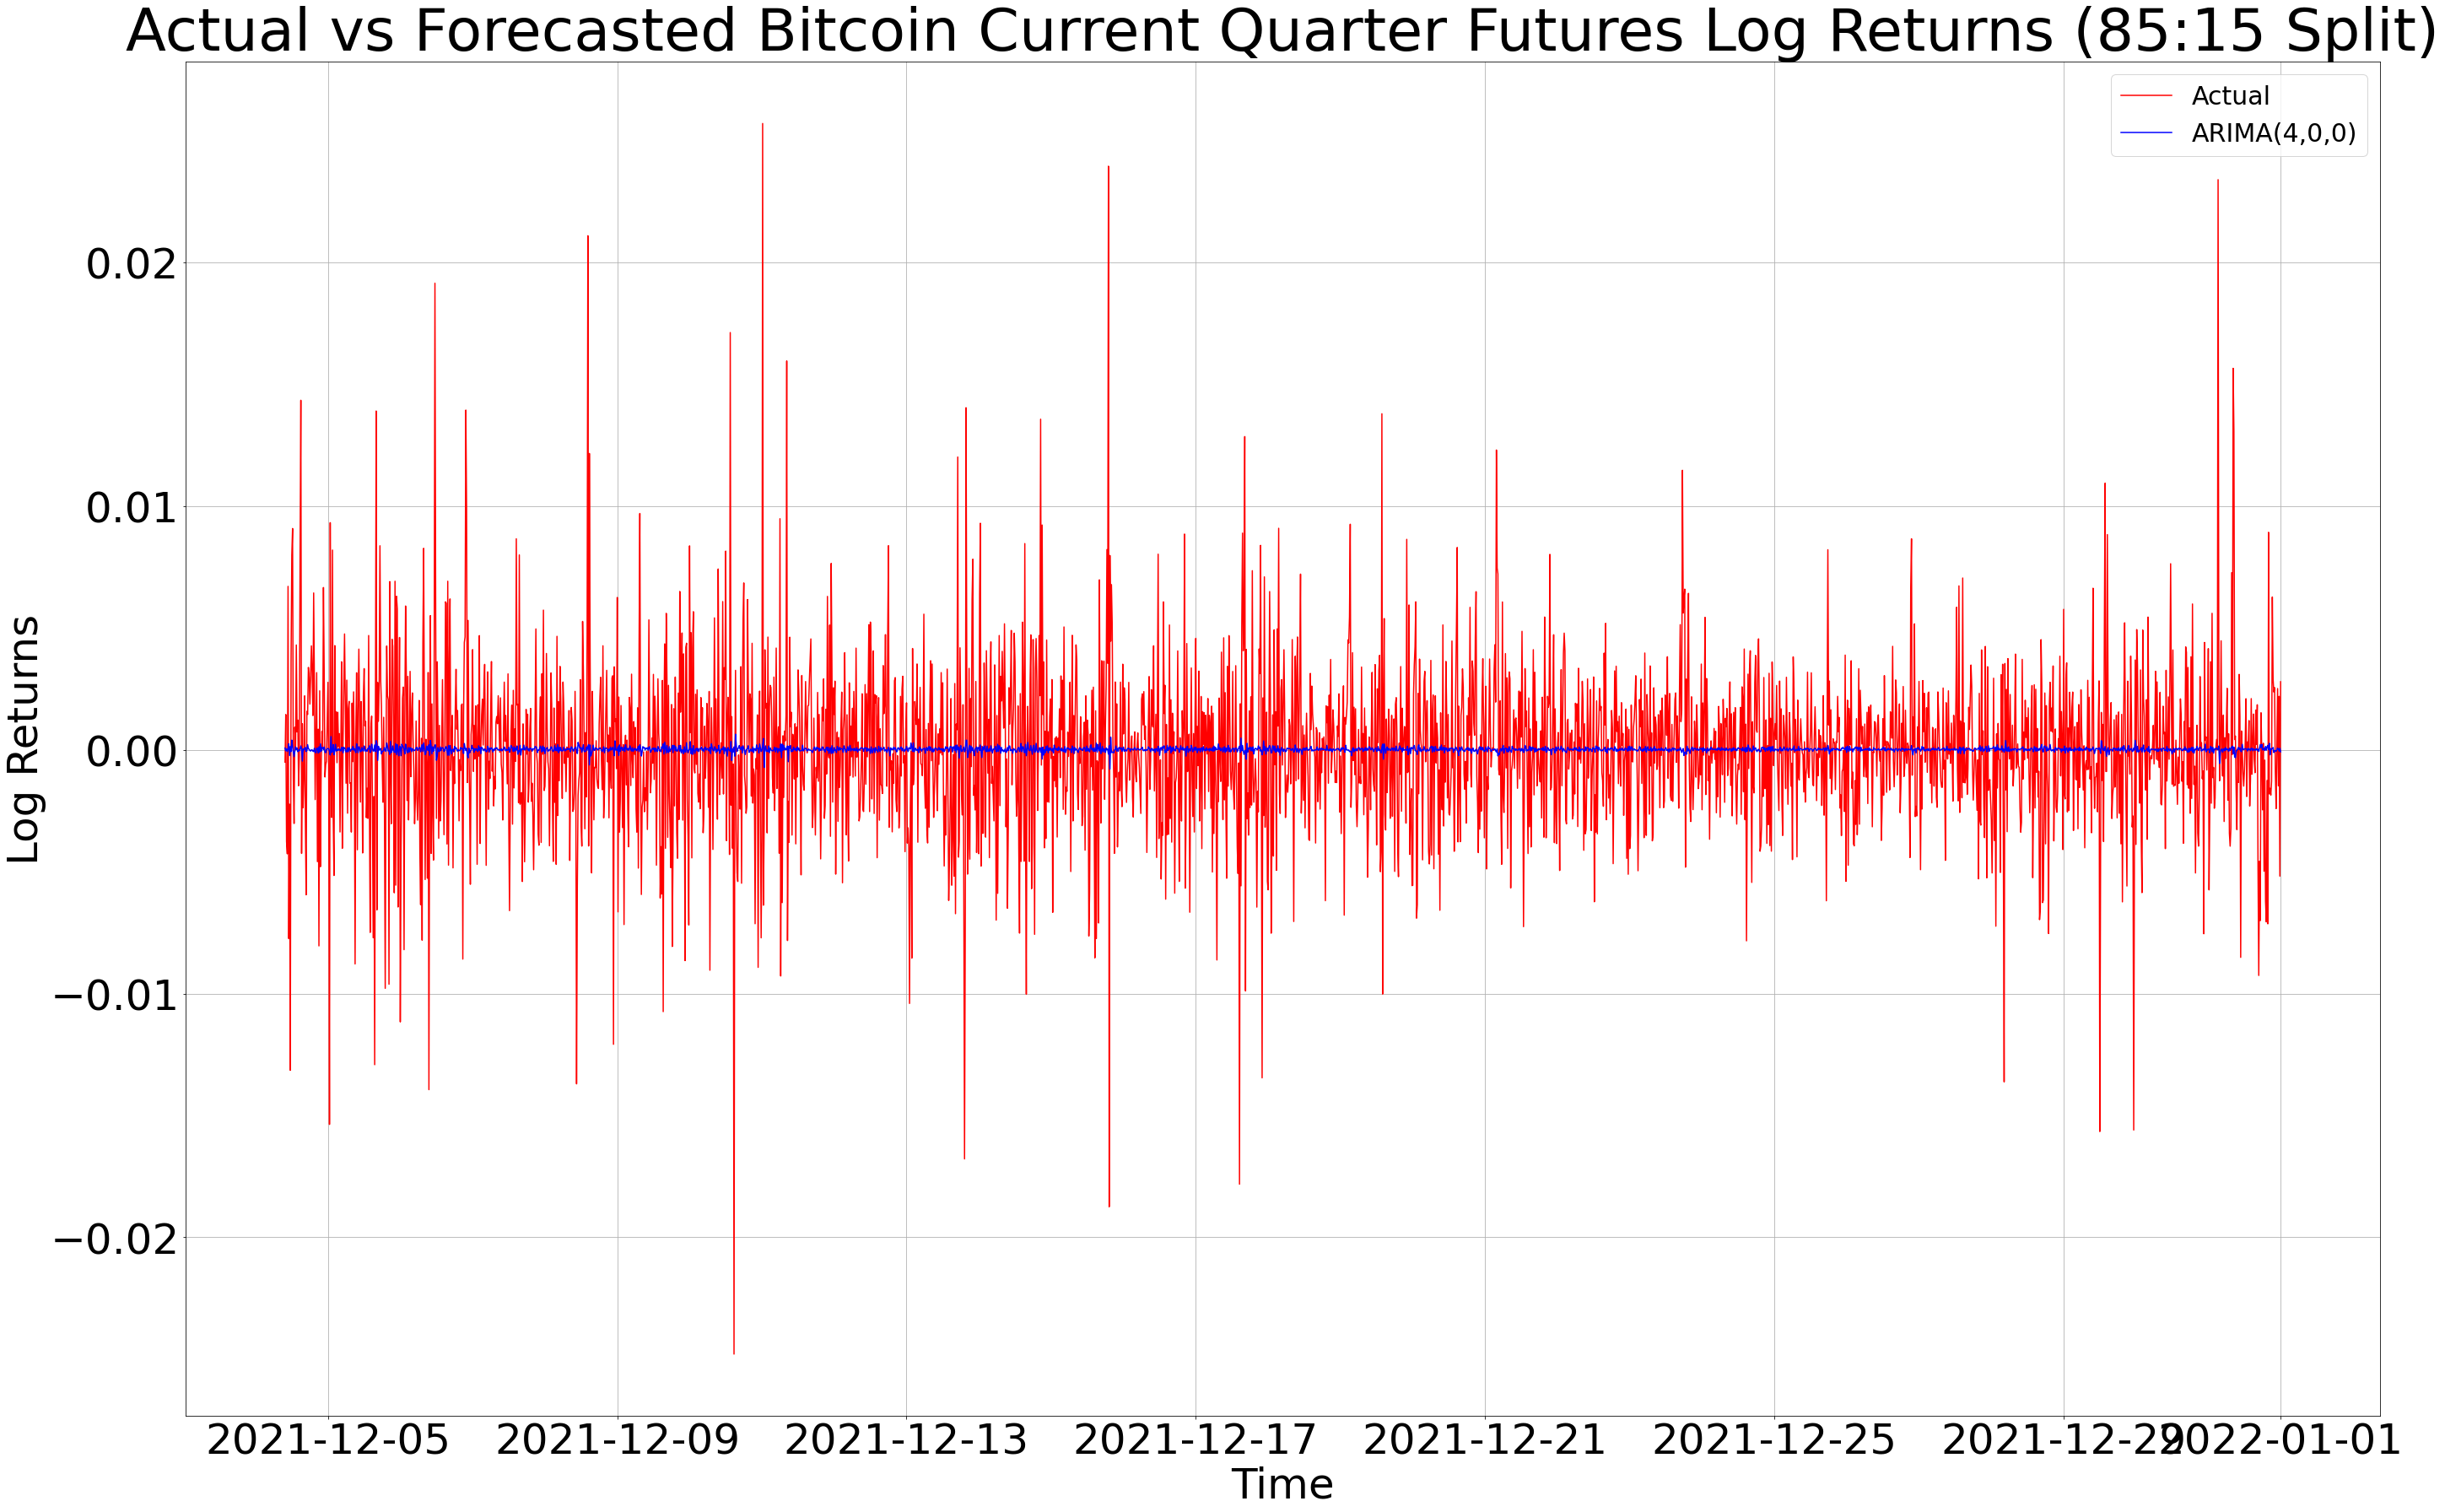

In [102]:
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (40,25)

ax.plot(test['time'], test['returns'], color='red', label='Actual')
ax.plot(test['time'], pred2, color='blue', label='ARIMA(4,0,0)')

ax.set_xlabel('Time', fontsize=50)
ax.set_ylabel('Log Returns', fontsize=50)
plt.title('Actual vs Forecasted Bitcoin Current Quarter Futures Log Returns (85:15 Split)', fontsize=70)

ax.grid(True)
ax.tick_params(axis='both', which='major', labelsize=50)
ax.legend(['Actual', 'ARIMA(4,0,0)'], prop={'size': 30})

plt.tight_layout()
plt.savefig('/Users/robinvandenberg/Desktop/Desktop – Robin’s MacBook Pro/Thesis/Scripts/Figures/ARIMA400.pdf')
plt.show()

In [61]:
# ARIMA(4,0,0)
from statsmodels.tools.eval_measures import mse, rmse, meanabs

mse400 = round(mse(np.array(test['returns']), np.array(test['ARIMA(4,0,0)'])), ndigits=10)
rmse400 = round(rmse(np.array(test['returns']), np.array(test['ARIMA(4,0,0)'])), ndigits=10)
mae400 = round(meanabs(np.array(test['returns']), np.array(test['ARIMA(4,0,0)'])), ndigits=10)

print("MSE:  ", mse400)
print("RMSE: ", rmse400)
print("MAE:  ", mae400)

MSE:   1.24058e-05
RMSE:  0.0035221918
MAE:   0.0024972379


## ARIMA(4,0,4)

In [30]:
for i in range(len(test)):
    model = ARIMA(training, order=(4,0,4))
    model_fit = model.fit()
    output = model_fit.forecast()
    pred.append(output)
    training.append(test['returns'][i])

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

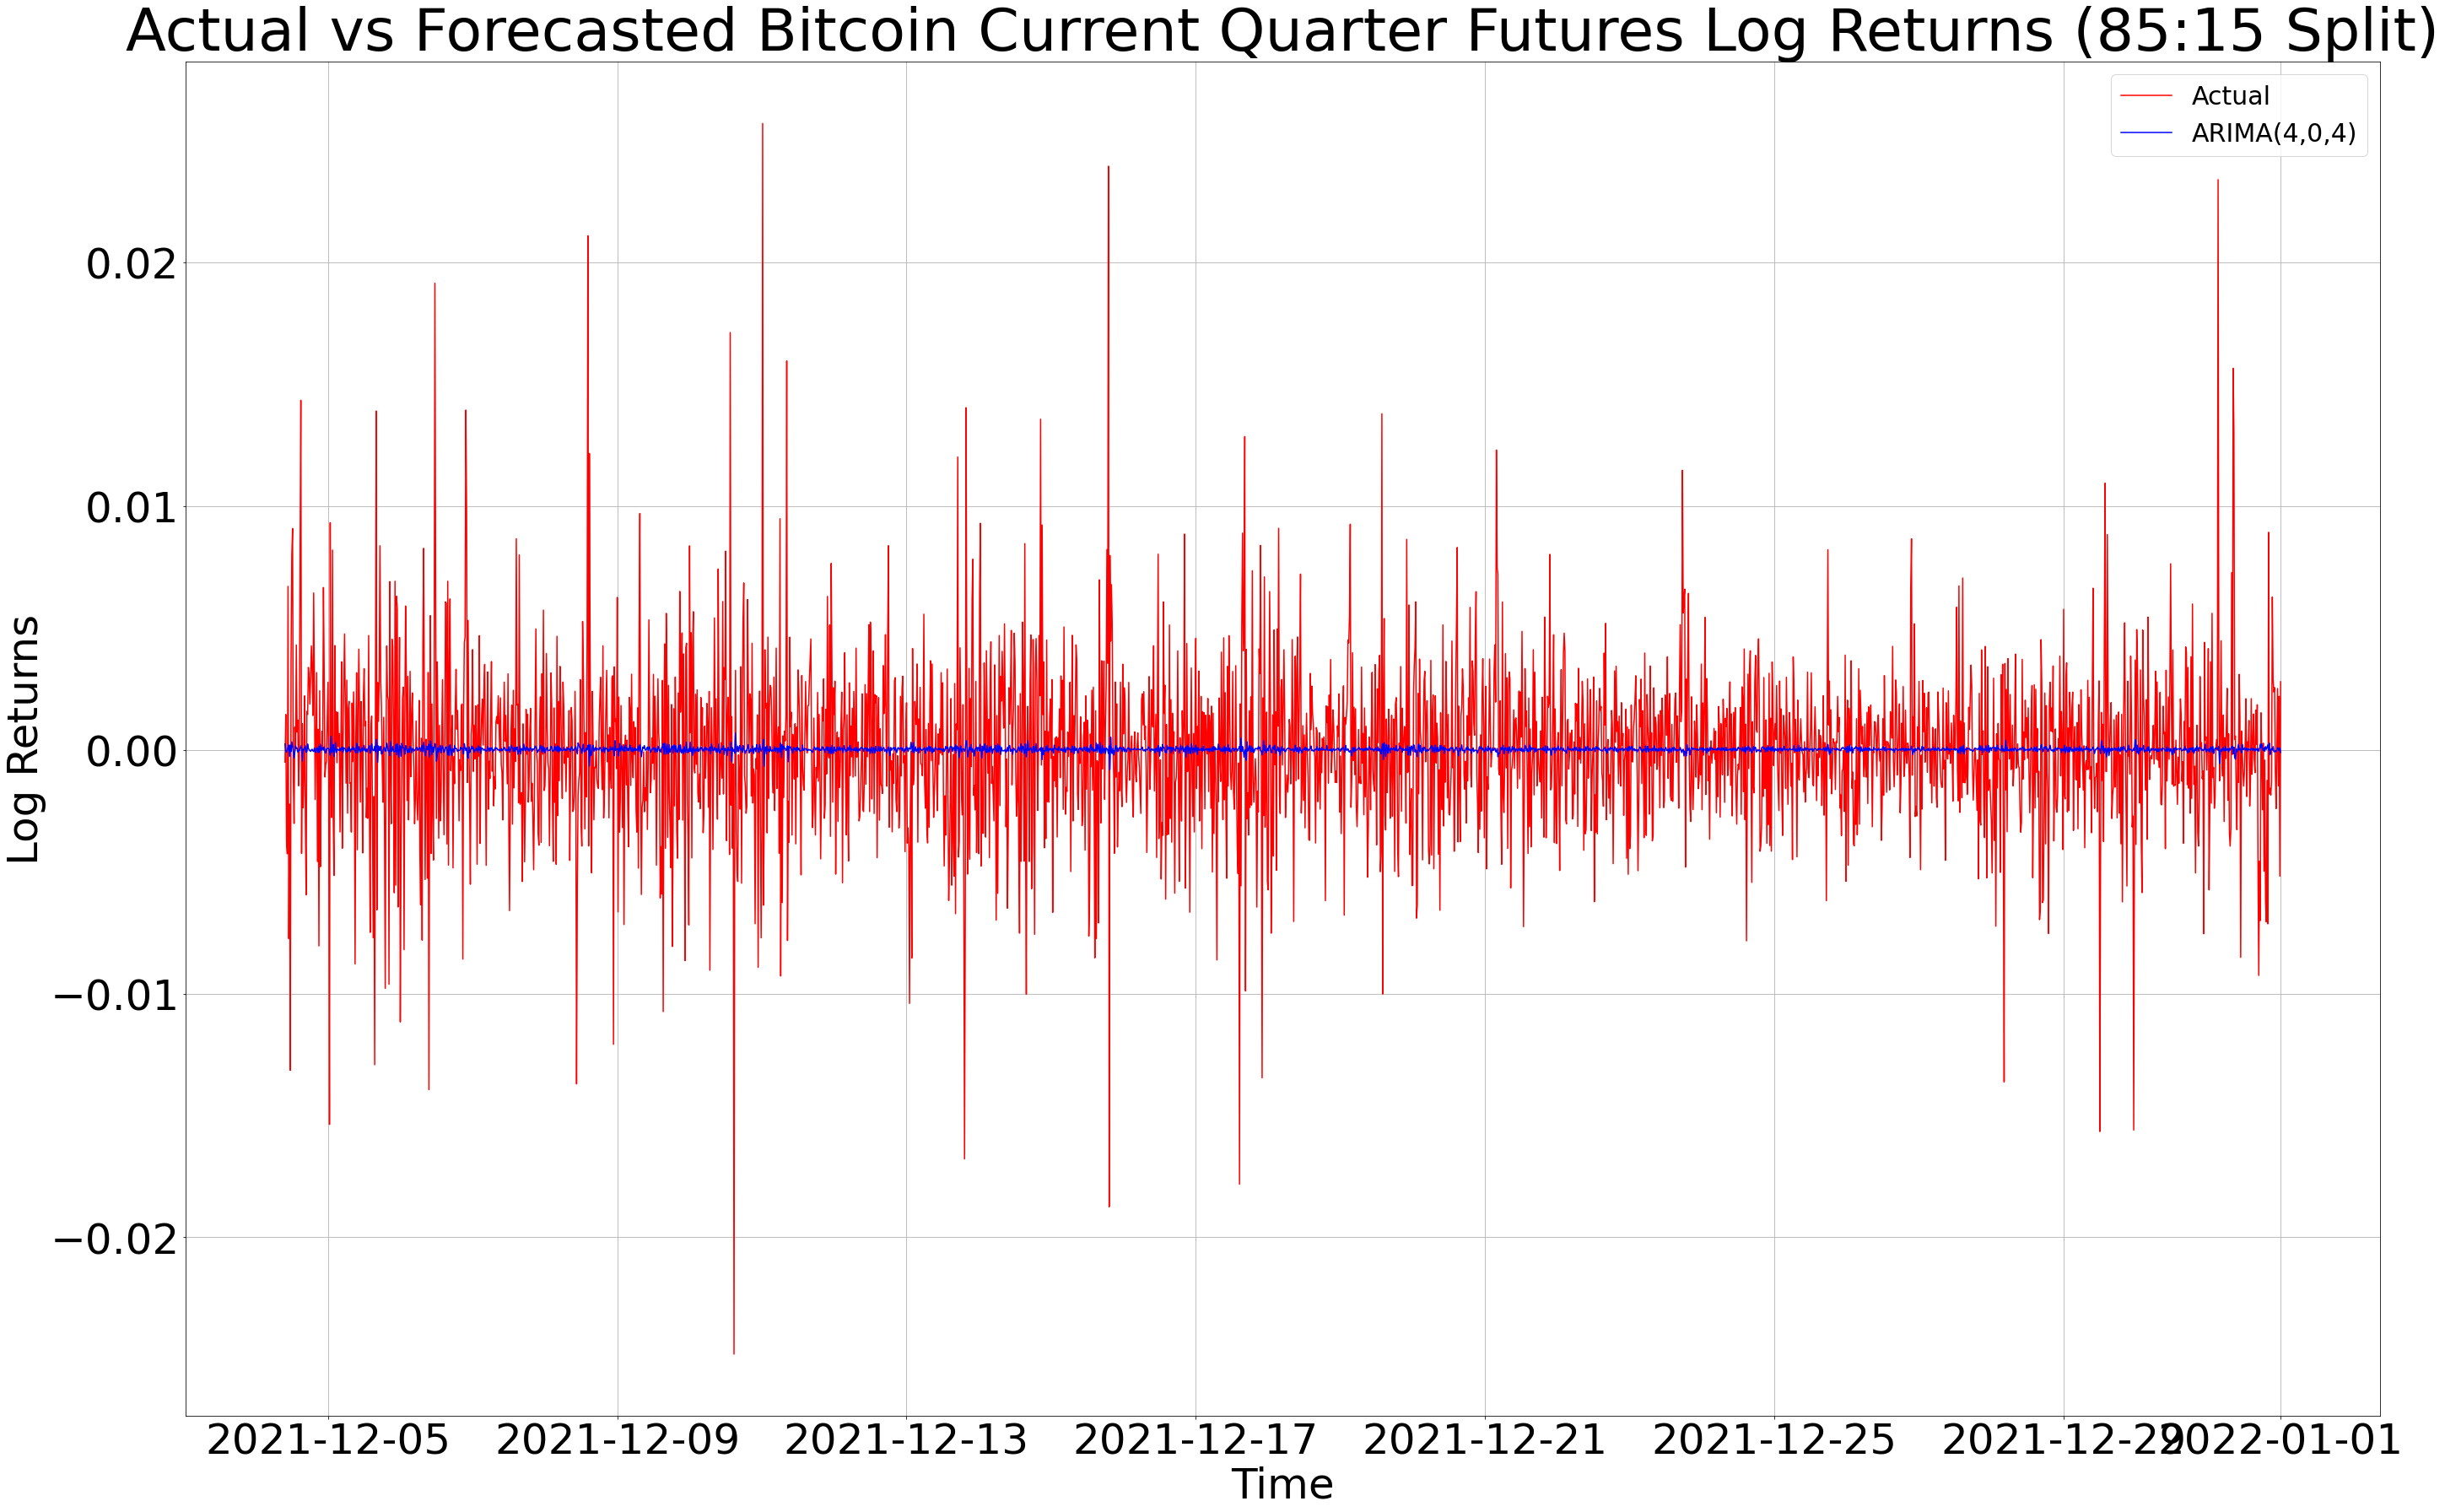

In [150]:
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (40,25)

ax.plot(test['time'], test['returns'], color='red', label='Actual')
ax.plot(test['time'], pred, color='blue', label='ARIMA(4,0,4)')

ax.set_xlabel('Time', fontsize=50)
ax.set_ylabel('Log Returns', fontsize=50)
plt.title('Actual vs Forecasted Bitcoin Current Quarter Futures Log Returns (85:15 Split)', fontsize=70)

ax.grid(True)
ax.tick_params(axis='both', which='major', labelsize=50)
ax.legend(['Actual', 'ARIMA(4,0,4)'], prop={'size': 30})

plt.tight_layout()
plt.savefig('/Users/robinvandenberg/Desktop/Desktop – Robin’s MacBook Pro/Thesis/Scripts/Figures/ARIMA404.pdf')
plt.show()


In [66]:
# ARIMA(4,0,4)
from statsmodels.tools.eval_measures import mse, rmse, meanabs

mse404 = round(mse(np.array(test['returns']), np.array(test['ARIMA(4,0,4)'])), ndigits=10)
rmse404 = round(rmse(np.array(test['returns']), np.array(test['ARIMA(4,0,4)'])), ndigits=10)
mae404 = round(meanabs(np.array(test['returns']), np.array(test['ARIMA(4,0,4)'])), ndigits=10)

print("MSE:  ", mse404)
print("RMSE: ", rmse404)
print("MAE:  ", mae404)

MSE:   1.24079e-05
RMSE:  0.0035224907
MAE:   0.002498334


## ARIMA Comparison

In [67]:
forecasts = pd.DataFrame()
forecasts['Measure'] = ['MSE', 'RMSE', 'MAE']
forecasts = forecasts.set_index('Measure')
forecasts['ARIMA(0,0,2)'] = [mse002, rmse002, mae002]
forecasts['ARIMA(4,0,0)'] = [mse400, rmse400, mae400]
forecasts['ARIMA(4,0,4)'] = [mse404, rmse404, mae404]
forecasts.to_excel('/Users/robinvandenberg/Desktop/Desktop – Robin’s MacBook Pro/Thesis/Scripts/Tables/ARIMA_85.xlsx')

with open('/Users/robinvandenberg/Desktop/Desktop – Robin’s MacBook Pro/Thesis/Scripts/Tables/ARIMA_85.tex','w') as tf:
    tf.write(forecasts.to_latex())

forecasts

/var/folders/tv/yf2rtv1j16z862b1fzdggrth0000gn/T/ipykernel_64187/1101633440.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tf.write(forecasts.to_latex())


ARIMA(0,0,2)  ARIMA(4,0,0)  ARIMA(4,0,4)
Measure                                          
MSE          0.000012      0.000012      0.000012
RMSE         0.003521      0.003522      0.003522
MAE          0.002497      0.002497      0.002498

# 4. Forecasting

# 75:25 Split

In [88]:
# create training sample data set
train_size = int(0.75 * len(main))
train = main[:train_size]
test = main[train_size:]

In [89]:
training = list(train['returns'])
forecast75 = []

for i in range(len(test)):
    model = ARIMA(training, order=(0,0,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    forecast75.append(output)
    training.append(test['returns'][i])
    

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/robinvandenberg/Anaconda/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [90]:
test['time'] = pd.to_datetime(test['time'])

forecast75 = pd.DataFrame(forecast75, columns=['ARIMA(0,0,2)_75'])
forecast75 = forecast75.join(test['time'])
forecast75 = forecast75.join(test['returns'], how='left')

forecast75

ARIMA(0,0,2)_75                time   returns
0           -0.000089 2021-11-16 00:00:00 -0.013611
1           -0.000086 2021-11-16 00:15:00 -0.002786
2            0.000367 2021-11-16 00:30:00  0.003131
3            0.000165 2021-11-16 00:45:00 -0.004551
4           -0.000113 2021-11-16 01:00:00 -0.008177
...               ...                 ...       ...
4412         0.000073 2021-12-31 23:00:00  0.002515
4413         0.000031 2021-12-31 23:15:00 -0.001479
4414        -0.000054 2021-12-31 23:30:00  0.002196
4415         0.000069 2021-12-31 23:45:00 -0.005182
4416        -0.000077 2022-01-01 00:00:00  0.002795

[4417 rows x 3 columns]

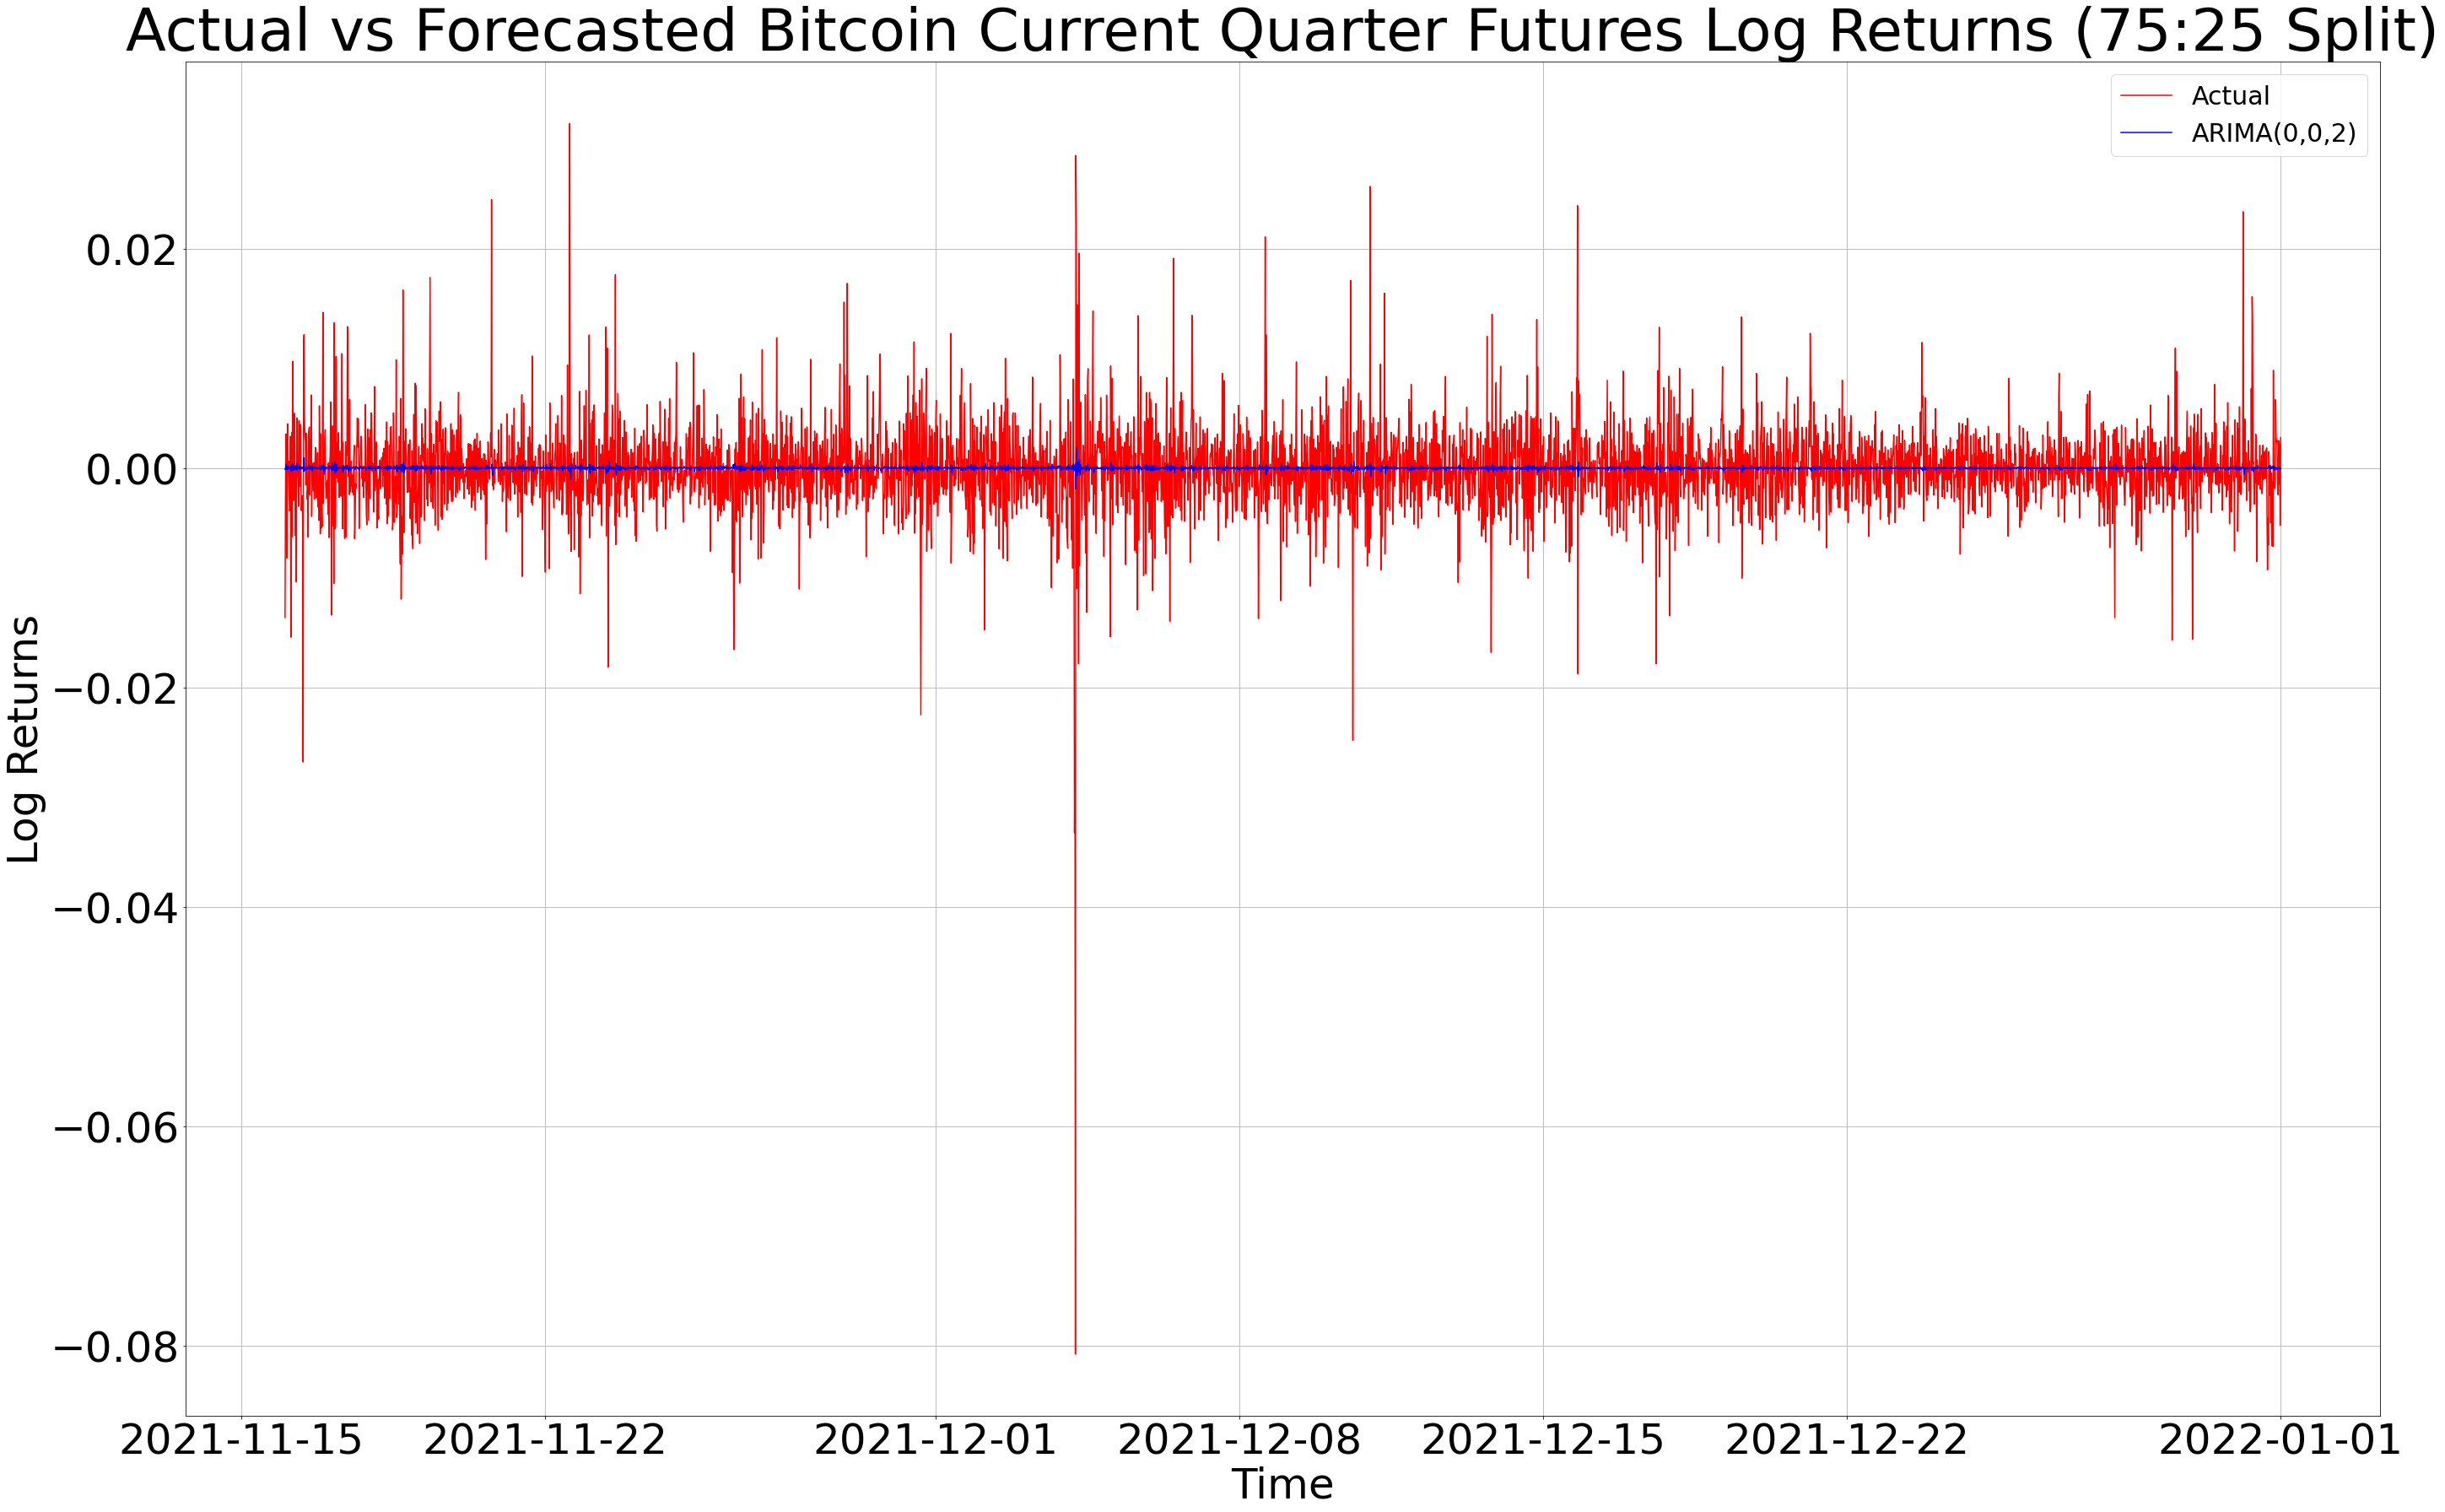

In [91]:
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (40,25)

ax.plot(forecast75['time'], forecast75['returns'], color='red', label='Actual')
ax.plot(forecast75['time'], forecast75['ARIMA(0,0,2)_75'], color='blue', label='ARIMA(0,0,2)')

ax.set_xlabel('Time', fontsize=50)
ax.set_ylabel('Log Returns', fontsize=50)
plt.title('Actual vs Forecasted Bitcoin Current Quarter Futures Log Returns (75:25 Split)', fontsize=70)

ax.grid(True)
ax.tick_params(axis='both', which='major', labelsize=50)
ax.legend(['Actual', 'ARIMA(0,0,2)'], prop={'size': 30})

plt.tight_layout()
plt.savefig('/Users/robinvandenberg/Desktop/Desktop – Robin’s MacBook Pro/Thesis/Scripts/Figures/ARIMA_75.pdf')
plt.show()

In [92]:
from statsmodels.tools.eval_measures import mse, rmse, meanabs

mse002_75 = round(mse(np.array(forecast75['returns']), np.array(forecast75['ARIMA(0,0,2)_75'])), ndigits=10)
rmse002_75 = round(rmse(np.array(forecast75['returns']), np.array(forecast75['ARIMA(0,0,2)_75'])), ndigits=10)
mae002_75 = round(meanabs(np.array(forecast75['returns']), np.array(forecast75['ARIMA(0,0,2)_75'])), ndigits=10)

print("MSE:  ", mse002_75)
print("RMSE: ", rmse002_75)
print("MAE:  ", mae002_75)

MSE:   1.58471e-05
RMSE:  0.0039808402
MAE:   0.0026525438


# 95:5 Split

In [68]:
# create training sample data set
train_size = int(0.95 * len(main))
train = main[:train_size]
test = main[train_size:]

In [69]:
training = list(train['returns'])
forecast95 = []

for i in range(len(test)):
    model = ARIMA(training, order=(0,0,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    forecast95.append(output)
    training.append(test['returns'][i])

In [85]:
test['time'] = pd.to_datetime(test['time'])

forecast95 = pd.DataFrame(forecast95, columns=['ARIMA(0,0,2)_95'])
forecast95 = forecast95.join(test['time'])
forecast95 = forecast95.join(test['returns'], how='left')

forecast95

ARIMA(0,0,2)_95                time   returns
0           0.000054 2021-12-22 19:15:00  0.000307
1          -0.000058 2021-12-22 19:30:00  0.003432
2           0.000036 2021-12-22 19:45:00  0.000754
3          -0.000064 2021-12-22 20:00:00  0.001161
4           0.000009 2021-12-22 20:15:00 -0.001385
..               ...                 ...       ...
879         0.000073 2021-12-31 23:00:00  0.002515
880         0.000031 2021-12-31 23:15:00 -0.001479
881        -0.000054 2021-12-31 23:30:00  0.002196
882         0.000069 2021-12-31 23:45:00 -0.005182
883        -0.000077 2022-01-01 00:00:00  0.002795

[884 rows x 3 columns]

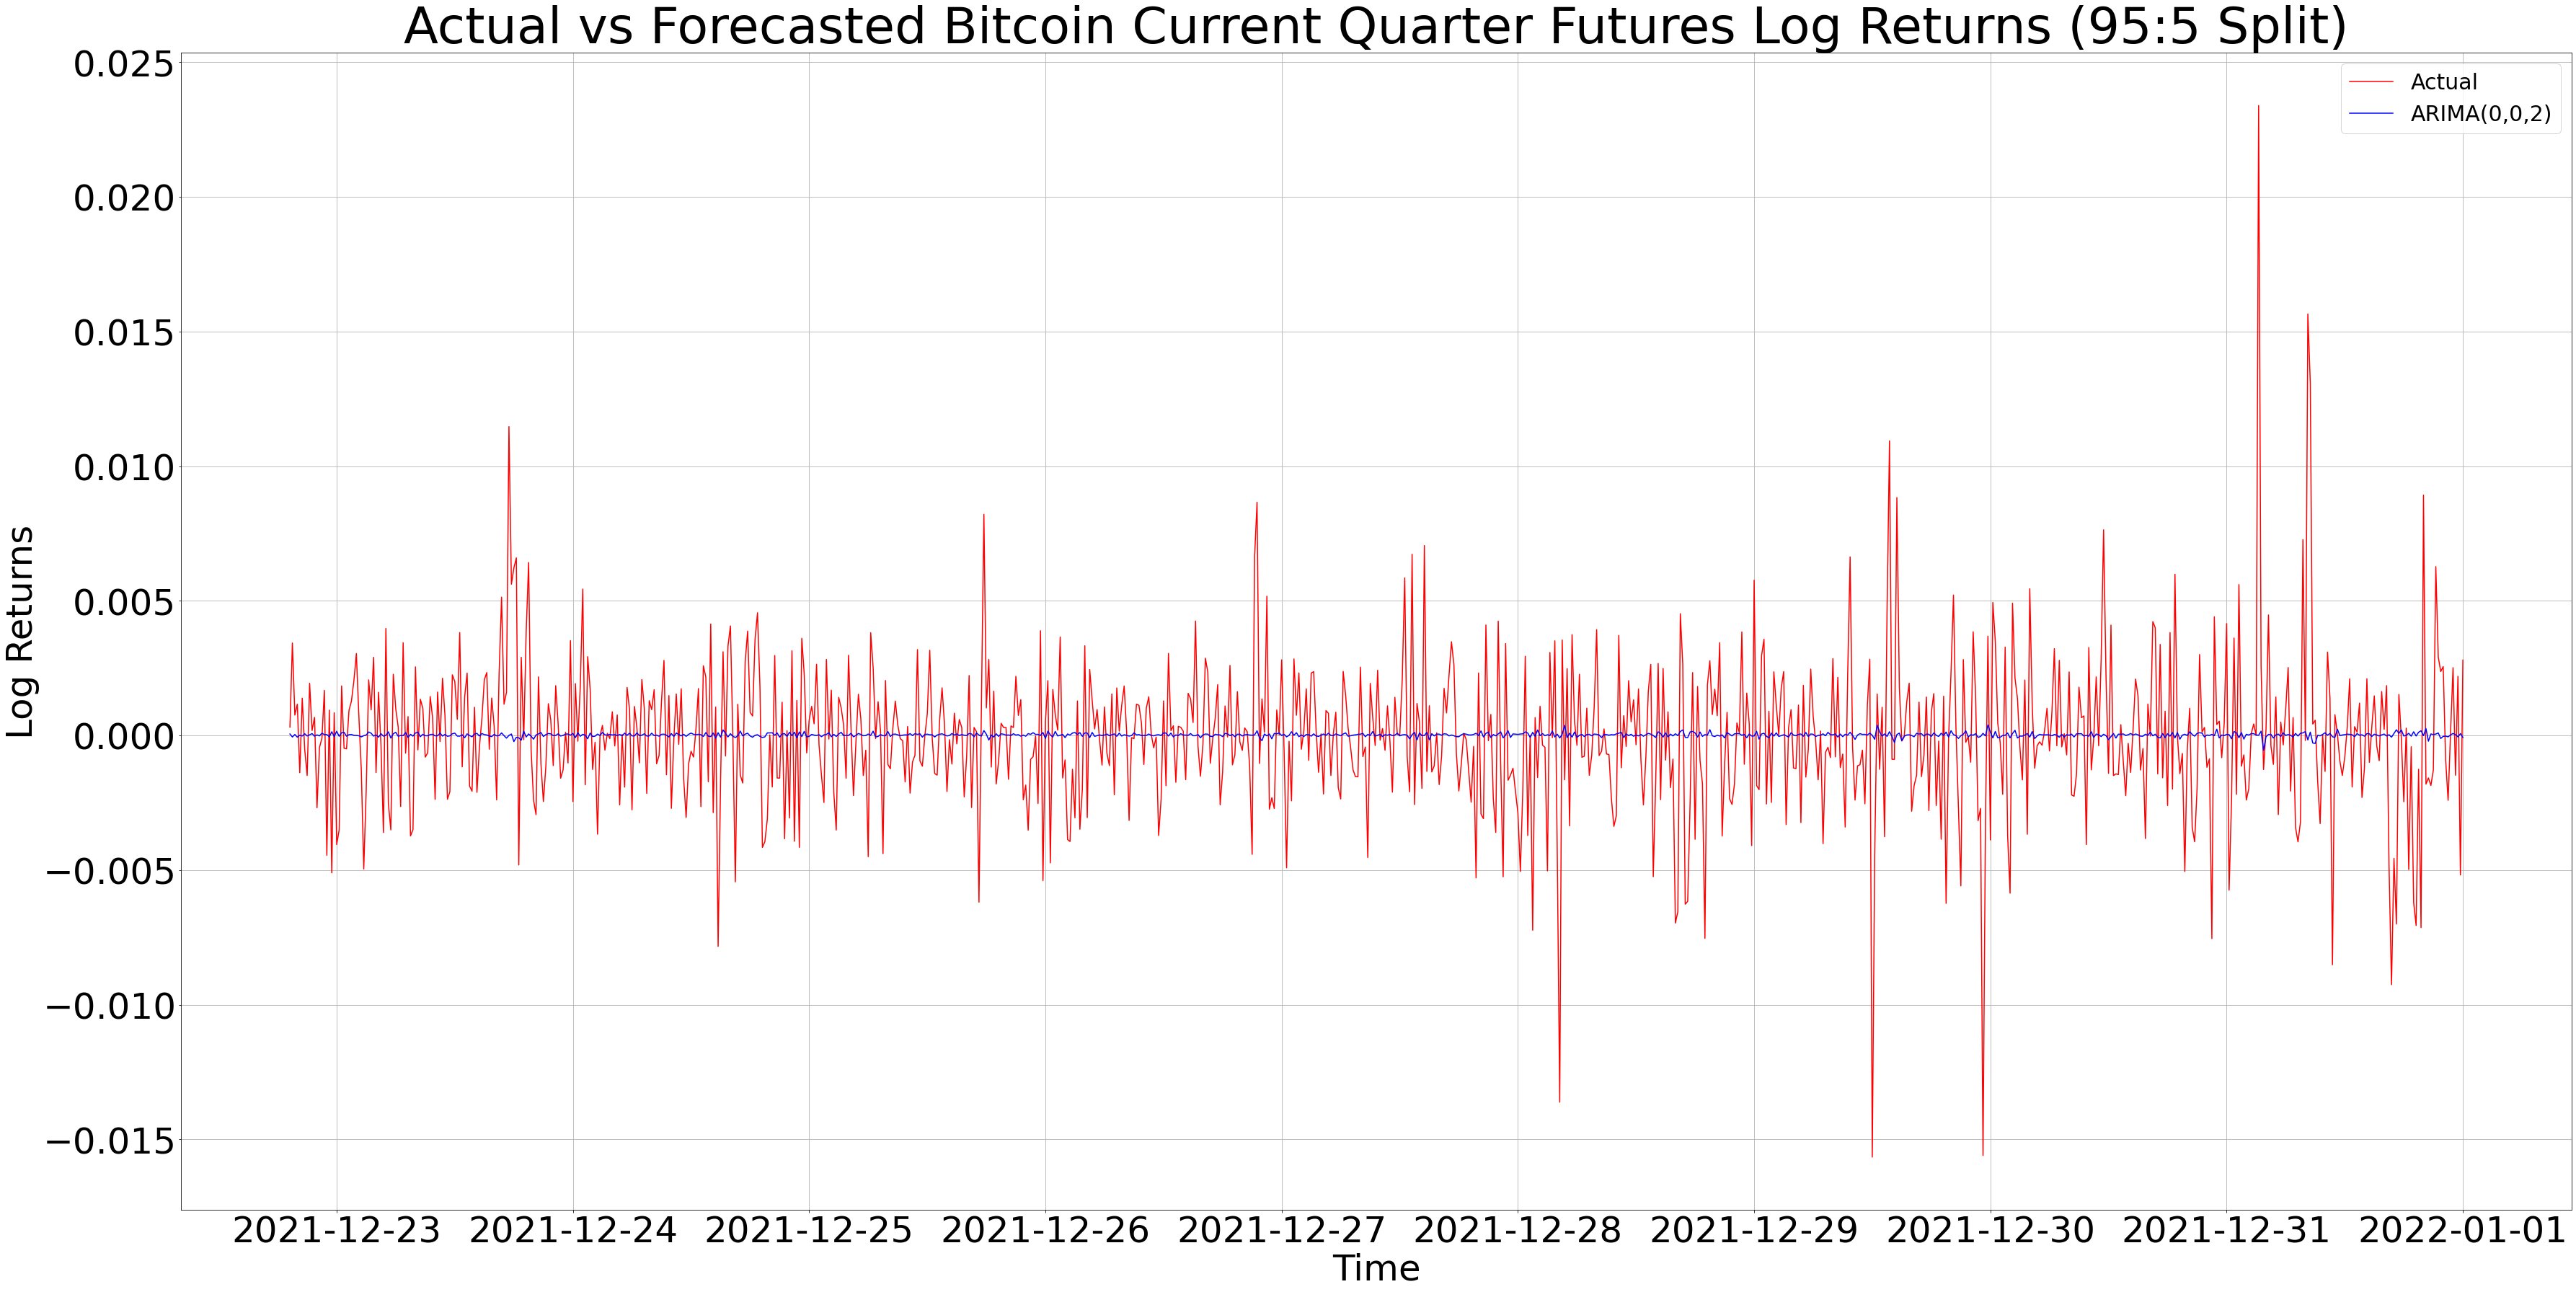

In [95]:
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (40,35)

ax.plot(forecast95['time'], forecast95['returns'], color='red', label='Actual')
ax.plot(forecast95['time'], forecast95['ARIMA(0,0,2)_95'], color='blue', label='ARIMA(0,0,2)')

ax.set_xlabel('Time', fontsize=50)
ax.set_ylabel('Log Returns', fontsize=50)
plt.title('Actual vs Forecasted Bitcoin Current Quarter Futures Log Returns (95:5 Split)', fontsize=70)

ax.grid(True)
ax.tick_params(axis='both', which='major', labelsize=50)
ax.legend(['Actual', 'ARIMA(0,0,2)'], prop={'size': 30})

plt.tight_layout()
plt.savefig('/Users/robinvandenberg/Desktop/Desktop – Robin’s MacBook Pro/Thesis/Scripts/Figures/ARIMA_95.pdf')
plt.show()

In [87]:
from statsmodels.tools.eval_measures import mse, rmse, meanabs

mse002_95 = round(mse(np.array(forecast95['returns']), np.array(forecast95['ARIMA(0,0,2)_95'])), ndigits=10)
rmse002_95 = round(rmse(np.array(forecast95['returns']), np.array(forecast95['ARIMA(0,0,2)_95'])), ndigits=10)
mae002_95 = round(meanabs(np.array(forecast95['returns']), np.array(forecast95['ARIMA(0,0,2)_95'])), ndigits=10)

print("MSE:  ", mse002_95)
print("RMSE: ", rmse002_95)
print("MAE:  ", mae002_95)

MSE:   8.512e-06
RMSE:  0.0029175328
MAE:   0.0020437453


# Forecast Accuracy

In [93]:
ARIMA200 = pd.DataFrame()
ARIMA200['Measure'] = ['MSE', 'RMSE', 'MAE']
ARIMA200 = ARIMA200.set_index('Measure')
ARIMA200['75:25'] = [mse002_75, rmse002_75, mae002_75]
ARIMA200['85:15'] = [mse002, rmse002, mae002]
ARIMA200['95:5'] = [mse002_95, rmse002_95, mae002_95]
ARIMA200.to_excel('/Users/robinvandenberg/Desktop/Desktop – Robin’s MacBook Pro/Thesis/Scripts/Tables/ARIMA_all.xlsx')

with open('/Users/robinvandenberg/Desktop/Desktop – Robin’s MacBook Pro/Thesis/Scripts/Tables/ARIMA_all.tex','w') as tf:
    tf.write(ARIMA200.to_latex())

ARIMA200

/var/folders/tv/yf2rtv1j16z862b1fzdggrth0000gn/T/ipykernel_64187/964002258.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tf.write(ARIMA200.to_latex())


75:25     85:15      95:5
Measure                              
MSE      0.000016  0.000012  0.000009
RMSE     0.003981  0.003521  0.002918
MAE      0.002653  0.002497  0.002044

# Naive Mean Forecast

In [113]:
# create training sample data set
train_size = int(0.75 * len(main))
train = main[:train_size]
test = main[train_size:]

mean = np.full( len(test), np.mean(train['returns']) )

from statsmodels.tools.eval_measures import mse, rmse, meanabs

mse_mean = round( mse( test['returns'], mean ), ndigits=10)
rmse_mean = round( rmse(test['returns'] , mean ), ndigits=10)
mae_mean = round( meanabs( test['returns'] , mean ), ndigits=10)

print("MSE:  ", mse_mean)
print("RMSE: ", rmse_mean)
print("MAE:  ", mae_mean)

MSE:   1.58156e-05
RMSE:  0.0039768817
MAE:   0.0026516563


In [114]:
# create training sample data set
train_size = int(0.85 * len(main))
train = main[:train_size]
test = main[train_size:]

mean = np.full( len(test), np.mean(train['returns']) )

from statsmodels.tools.eval_measures import mse, rmse, meanabs

mse_mean = round( mse( test['returns'], mean ), ndigits=10)
rmse_mean = round( rmse(test['returns'] , mean ), ndigits=10)
mae_mean = round( meanabs( test['returns'] , mean ), ndigits=10)

print("MSE:  ", mse_mean)
print("RMSE: ", rmse_mean)
print("MAE:  ", mae_mean)

MSE:   1.239e-05
RMSE:  0.0035199402
MAE:   0.0024959156


In [115]:
# create training sample data set
train_size = int(0.95 * len(main))
train = main[:train_size]
test = main[train_size:]

mean = np.full( len(test), np.mean(train['returns']) )

from statsmodels.tools.eval_measures import mse, rmse, meanabs

mse_mean = round( mse( test['returns'], mean ), ndigits=10)
rmse_mean = round( rmse(test['returns'] , mean ), ndigits=10)
mae_mean = round( meanabs( test['returns'] , mean ), ndigits=10)

print("MSE:  ", mse_mean)
print("RMSE: ", rmse_mean)
print("MAE:  ", mae_mean)

MSE:   8.5033e-06
RMSE:  0.0029160472
MAE:   0.0020427607
